# **Depedencies**

In [71]:
import torch
import os
from tqdm import tqdm

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, utils

from math import sqrt

import numpy as np
import os

# **Project Parameters**

In [2]:
DATAROOT = "data"
lr = 0.001
input_code_size = 128
NUM_CHANNELS = 128
BATCH_SIZE = 4 #Batch Size during 1 iteration
START_SIZE = 1 #At which size do we start the programm
NUM_ITER = 250000 #How many iterations in total

# **Data Preparation**

In [3]:
# Create the dataset

# This time we need to create responsive dataloader that will adapt itself depending on
# the size that we are currently treating

def pokemon_loader_folder(path):
    def loader(transform, image_size):
        data = datasets.ImageFolder(path, transform=transform)
        if image_size <= 64:
            data_loader = DataLoader(data, shuffle=True, batch_size=BATCH_SIZE,
                                     num_workers=4)
        else:
            data_loader = DataLoader(data, shuffle=True, batch_size=BATCH_SIZE//2,
                         num_workers=4)
        return data_loader
    return loader

def create_loader_depending_on_image_size(dataloader, image_size):
    transform = transforms.Compose([
        transforms.Resize(image_size+int(image_size*0.2)+1),
        transforms.RandomCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    loader = dataloader(transform, image_size)
    return loader

In [4]:
def upscale(feat):
    return F.interpolate(feat, scale_factor=2, mode='bilinear', align_corners=False)

# **Creating the Equalized Layers**

In [5]:
class EqualLR:
    def __init__(self, name):
        self.name = name

    def compute_weight(self, module):
        weight = getattr(module, self.name + '_orig')
        fan_in = weight.data.size(1) * weight.data[0][0].numel()

        return weight * sqrt(2 / fan_in)

    @staticmethod
    def apply(module, name):
        fn = EqualLR(name)

        weight = getattr(module, name)
        del module._parameters[name]
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        module.register_forward_pre_hook(fn)

        return fn

    def __call__(self, module, input):
        weight = self.compute_weight(module)
        setattr(module, self.name, weight)


def equal_lr(module, name='weight'):
    EqualLR.apply(module, name)

    return module


class EqualConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()
        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)


class EqualConvTranspose2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.ConvTranspose2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()
        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)

class EqualLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()

        linear = nn.Linear(in_dim, out_dim)
        linear.weight.data.normal_()
        linear.bias.data.zero_()

        self.linear = equal_lr(linear)

    def forward(self, input):
        return self.linear(input)

# **Creating the Convolution Block**

In [6]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, padding, kernel_size2=None, padding2=None):
        super().__init__()

        pad1 = padding
        pad2 = padding
        if padding2 is not None:
            pad2 = padding2

        kernel1 = kernel_size
        kernel2 = kernel_size
        if kernel_size2 is not None:
            kernel2 = kernel_size2

        convs = [EqualConv2d(in_channel, out_channel, kernel1, padding=pad1)]
        convs.append(nn.LeakyReLU(0.1))
        convs.append(EqualConv2d(out_channel, out_channel, kernel2, padding=pad2))
        convs.append(nn.LeakyReLU(0.1))

        self.conv = nn.Sequential(*convs)

    def forward(self, input):
        out = self.conv(input)
        return out

# **Generator**

In [7]:
class Generator(nn.Module):
    def __init__(self, input_code_dim=128, in_channel=128):
        super().__init__()
        self.input_dim = input_code_dim
        self.input_layer = nn.Sequential(
            EqualConvTranspose2d(input_code_dim, in_channel, 4, 1, 0),
            nn.LeakyReLU(0.1))

        self.progression_4 = ConvolutionBlock(in_channel, in_channel, 3, 1)
        self.progression_8 = ConvolutionBlock(in_channel, in_channel, 3, 1)
        self.progression_16 = ConvolutionBlock(in_channel, in_channel, 3, 1)
        self.progression_32 = ConvolutionBlock(in_channel, in_channel, 3, 1)
        self.progression_64 = ConvolutionBlock(in_channel, in_channel//2, 3, 1)
        self.progression_128 = ConvolutionBlock(in_channel//2, in_channel//4, 3, 1)

        self.to_rgb_8 = EqualConv2d(in_channel, 3, 1)
        self.to_rgb_16 = EqualConv2d(in_channel, 3, 1)
        self.to_rgb_32 = EqualConv2d(in_channel, 3, 1)
        self.to_rgb_64 = EqualConv2d(in_channel//2, 3, 1)
        self.to_rgb_128 = EqualConv2d(in_channel//4, 3, 1)
        
        self.max_step = 5
        
    # This allows the generator to multiply the output of the previous layer, in order
    # To make it a x2 sized picture
    def progress(self, feat, module):
        out = F.interpolate(feat, scale_factor=2, mode='bilinear', align_corners=False)
        out = module(out)
        return out

    def output(self, feat1, feat2, module1, module2, alpha):
        # Depending on the alpha, we add progressively a new layer 
        if 0 <= alpha < 1:
            skip_rgb = upscale(module1(feat1))
            out = (1-alpha)*skip_rgb + alpha*module2(feat2)
        else:
            out = module2(feat2)
        return out

    def forward(self, input, step=0, alpha=-1):
        if step > self.max_step:
            step = self.max_step

        out_4 = self.input_layer(input.view(-1, self.input_dim, 1, 1))
        out_4 = self.progression_4(out_4)
        out_8 = self.progress(out_4, self.progression_8)
        if step==1:
            return self.to_rgb_8(out_8)
        
        out_16 = self.progress(out_8, self.progression_16)
        if step==2:
            return self.output( out_8, out_16, self.to_rgb_8, self.to_rgb_16, alpha )
        
        out_32 = self.progress(out_16, self.progression_32)
        if step==3:
            return self.output( out_16, out_32, self.to_rgb_16, self.to_rgb_32, alpha )

        out_64 = self.progress(out_32, self.progression_64)
        if step==4:
            return self.output( out_32, out_64, self.to_rgb_32, self.to_rgb_64, alpha )
        
        out_128 = self.progress(out_64, self.progression_128)
        if step==5:
            return self.output( out_64, out_128, self.to_rgb_64, self.to_rgb_128, alpha )

# **Discriminator**

In [8]:
class Discriminator(nn.Module):
    def __init__(self, feat_dim=128):
        super().__init__()

        self.progression = nn.ModuleList([ConvolutionBlock(feat_dim//4, feat_dim//4, 3, 1),
                                          ConvolutionBlock(feat_dim//4, feat_dim//2, 3, 1),
                                          ConvolutionBlock(feat_dim//2, feat_dim, 3, 1),
                                          ConvolutionBlock(feat_dim, feat_dim, 3, 1),
                                          ConvolutionBlock(feat_dim, feat_dim, 3, 1),
                                          ConvolutionBlock(feat_dim, feat_dim, 3, 1),
                                          ConvolutionBlock(feat_dim+1, feat_dim, 3, 1, 4, 0)])

        self.from_rgb = nn.ModuleList([EqualConv2d(3, feat_dim//4, 1),
                                       EqualConv2d(3, feat_dim//4, 1),
                                       EqualConv2d(3, feat_dim//2, 1),
                                       EqualConv2d(3, feat_dim, 1),
                                       EqualConv2d(3, feat_dim, 1),
                                       EqualConv2d(3, feat_dim, 1),
                                       EqualConv2d(3, feat_dim, 1)])

        self.n_layer = len(self.progression)

        self.linear = EqualLinear(feat_dim, 1)

    def forward(self, input, step=0, alpha=-1):
        for i in range(step, -1, -1):
            index = self.n_layer - i - 1

            if i == step:
                out = self.from_rgb[index](input)

            if i == 0:
                out_std = torch.sqrt(out.var(0, unbiased=False) + 1e-8)
                mean_std = out_std.mean()
                mean_std = mean_std.expand(out.size(0), 1, 4, 4)
                out = torch.cat([out, mean_std], 1)

            out = self.progression[index](out)

            if i > 0:
                out = F.interpolate(out, scale_factor=0.5, mode='bilinear', align_corners=False)

                if i == step and 0 <= alpha < 1:
                    skip_rgb = F.interpolate(input, scale_factor=0.5, mode='bilinear', align_corners=False)
                    skip_rgb = self.from_rgb[index + 1](skip_rgb)
                    out = (1 - alpha) * skip_rgb + alpha * out

        out = out.squeeze(2).squeeze(2)
        out = self.linear(out)

        return out

# Training Function

In [9]:
def train(generator, discriminator, start_size, loader, num_iter=50000):
    step = start_size # can be 1 = 8, 2 = 16, 3 = 32, 4 = 64, 5 = 128
    data_loader = create_loader_depending_on_image_size(loader, 4 * 2 ** step)
    dataset = iter(data_loader)

    num_iter_remain = num_iter - (num_iter//5)*(step-1)

    # Progress Bar 
    pbar = tqdm(range(num_iter_remain))

    disc_loss_val = 0
    gen_loss_val = 0
    grad_loss_val = 0

    # Creating Saving Folder
    log_folder = 'log_folder'
    
    os.mkdir(log_folder)
    # To store the pictures
    os.mkdir(log_folder+'/sample')

    # Log for Discriminator & Generator Loss Value
    log_file_name = os.path.join(log_folder, 'generator_discriminator_values')
    log_file = open(log_file_name, 'w')
    log_file.write('generator,discriminator,gradient,alpha\n')
    log_file.close()

    # Initializing the parameters
    cuda0=torch.device('cuda:0')
    alpha = 0
    one = torch.tensor(1, dtype=torch.float, device=cuda0)
    mone = one * -1
    iteration = 0

    for i in pbar:
        # Clears up old gradients
        discriminator.zero_grad()

        # Alpha is the evolution rate, that will progressively
        # add the new output produced by the new layer added on top of the other
        # The more we enter in the iteration 
        alpha = min(1, (2/(num_iter//5)) * iteration)

        # If the number of iteration goes over the number 1/5 of the total iteration
        # We go to the next step and increase the size of the produced image.
        if iteration > num_iter//5:
            alpha = 0
            iteration = 0
            step += 1
            data_loader = create_loader_depending_on_image_size(loader, 4 * 2 ** step)
            dataset = iter(data_loader)

        try:
            real_image, label = next(dataset)
        except (OSError, StopIteration):
            # When the dataset iterator is over, we need to reload it
            dataset = iter(data_loader)
            real_image, label = next(dataset)

        iteration += 1

        ### 1. train Discriminator
        ## Takes a new image and compare the prediction vs 
        b_size = real_image.size(0)
        real_image = real_image.to(device)
        label = label.to(device)
        real_predict = discriminator(real_image, step=step, alpha=alpha)
        real_predict = real_predict.mean() - 0.001 * (real_predict ** 2).mean()
        real_predict.backward(mone)

        # sample input data: vector for Generator
        # We generate a fake vector
        gen_z = torch.randn(b_size, input_code_size).to(device)

        fake_image = generator(gen_z, step=step, alpha=alpha)
        fake_predict = discriminator(fake_image.detach(), step=step, alpha=alpha)
        fake_predict = fake_predict.mean()
        fake_predict.backward(one)


        eps = torch.rand(b_size, 1, 1, 1).to(device)
        x_hat = eps * real_image.data + (1 - eps) * fake_image.detach().data
        x_hat.requires_grad = True
        hat_predict = discriminator(x_hat, step=step, alpha=alpha)
        grad_x_hat = grad(outputs=hat_predict.sum(), inputs=x_hat, create_graph=True)[0]
        grad_penalty = ((grad_x_hat.view(grad_x_hat.size(0), -1).norm(2, dim=1) - 1)**2).mean()
        grad_penalty = 10 * grad_penalty
        grad_penalty.backward()
        grad_loss_val += grad_penalty.item()
        disc_loss_val += (real_predict - fake_predict).item()

        # Take a step based on the gradient, for the optimizer
        d_optimizer.step()

        ### 2. train Generator
        generator.zero_grad()
        discriminator.zero_grad()
        
        predict = discriminator(fake_image, step=step, alpha=alpha)

        loss = -predict.mean()
        gen_loss_val += loss.item()


        loss.backward()
        g_optimizer.step()
        accumulate(g_running, generator)

        # Save the images into a folder
        if (i + 1) % 1000 == 0 or i==0:
            with torch.no_grad():
                images = g_running(torch.randn(5 * 10, input_code_size).to(device), step=step, alpha=alpha).data.cpu()

                utils.save_image(
                    images,
                    f'{log_folder}/sample/{str(i + 1).zfill(6)}.png',
                    nrow=10,
                    normalize=True,
                    range=(-1, 1))
        
        # Save the Generator Loss Value, Discriminator Loss Value and the Alpha value every 500 iterations
        if (i+1)%500 == 0:
            state_msg = (f'{i + 1}; G: {gen_loss_val/500:.3f}; D: {disc_loss_val/500:.3f};'
                f' Grad: {grad_loss_val/500:.3f}; Alpha: {alpha:.3f}')
            
            log_file = open(log_file_name, 'a+')
            new_line = "%.5f,%.5f,%.5f,%.5f\n"%(gen_loss_val/500, disc_loss_val/500,grad_loss_val/500, alpha)
            log_file.write(new_line)
            log_file.close()

            disc_loss_val = 0
            gen_loss_val = 0
            grad_loss_val = 0

            print(state_msg)

# **Running the Model**

In [10]:
def accumulate(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(1 - decay, par2[k].data)

In [11]:
device = torch.device("cuda:0")

generator = Generator(in_channel=NUM_CHANNELS, input_code_dim=input_code_size).to(device)
discriminator = Discriminator(feat_dim=NUM_CHANNELS).to(device)
g_running = Generator(in_channel=NUM_CHANNELS, input_code_dim=input_code_size).to(device)

g_running.train(False)

g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.0, 0.99))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.0, 0.99))

accumulate(g_running, generator, 0)

loader = pokemon_loader_folder(DATAROOT)

train(generator, discriminator, START_SIZE, loader, NUM_ITER)

  0%|          | 504/250000 [00:15<2:19:10, 29.88it/s]

500; G: -0.054; D: 0.056; Grad: 0.069; Alpha: 0.020


  0%|          | 1006/250000 [00:32<2:07:15, 32.61it/s]

1000; G: 0.356; D: -0.017; Grad: 0.062; Alpha: 0.040


  1%|          | 1504/250000 [00:47<2:32:10, 27.22it/s]

1500; G: 0.511; D: 0.068; Grad: 0.059; Alpha: 0.060


  1%|          | 2007/250000 [01:02<2:03:22, 33.50it/s]

2000; G: 0.720; D: 0.231; Grad: 0.078; Alpha: 0.080


  1%|          | 2506/250000 [01:18<2:04:04, 33.25it/s]

2500; G: 0.899; D: 0.254; Grad: 0.097; Alpha: 0.100


  1%|          | 3004/250000 [01:33<2:02:30, 33.60it/s]

3000; G: 0.769; D: 0.222; Grad: 0.085; Alpha: 0.120


  1%|▏         | 3504/250000 [01:48<2:09:03, 31.83it/s]

3500; G: 1.210; D: 0.399; Grad: 0.101; Alpha: 0.140


  2%|▏         | 4007/250000 [02:04<1:57:18, 34.95it/s]

4000; G: 1.346; D: 0.395; Grad: 0.102; Alpha: 0.160


  2%|▏         | 4503/250000 [02:21<3:53:31, 17.52it/s]

4500; G: 1.170; D: 0.348; Grad: 0.093; Alpha: 0.180


  2%|▏         | 5004/250000 [02:39<2:19:23, 29.29it/s]

5000; G: 0.902; D: 0.263; Grad: 0.077; Alpha: 0.200


  2%|▏         | 5506/250000 [02:54<1:55:18, 35.34it/s]

5500; G: 0.586; D: 0.151; Grad: 0.080; Alpha: 0.220


  2%|▏         | 6006/250000 [03:08<1:53:20, 35.88it/s]

6000; G: 0.206; D: 0.129; Grad: 0.069; Alpha: 0.240


  3%|▎         | 6506/250000 [03:22<2:06:31, 32.08it/s]

6500; G: 0.464; D: 0.109; Grad: 0.065; Alpha: 0.260


  3%|▎         | 7006/250000 [03:36<1:51:45, 36.24it/s]

7000; G: 0.342; D: 0.116; Grad: 0.067; Alpha: 0.280


  3%|▎         | 7506/250000 [03:50<1:56:10, 34.79it/s]

7500; G: 0.196; D: 0.056; Grad: 0.063; Alpha: 0.300


  3%|▎         | 8007/250000 [04:06<1:55:22, 34.96it/s]

8000; G: 0.202; D: 0.063; Grad: 0.056; Alpha: 0.320


  3%|▎         | 8507/250000 [04:21<1:54:27, 35.16it/s]

8500; G: 0.462; D: 0.068; Grad: 0.055; Alpha: 0.340


  4%|▎         | 9005/250000 [04:36<2:10:06, 30.87it/s]

9000; G: 0.183; D: 0.096; Grad: 0.060; Alpha: 0.360


  4%|▍         | 9506/250000 [04:53<2:10:40, 30.67it/s]

9500; G: 0.416; D: 0.125; Grad: 0.059; Alpha: 0.380


  4%|▍         | 10005/250000 [05:08<1:52:57, 35.41it/s]

10000; G: 0.433; D: 0.116; Grad: 0.058; Alpha: 0.400


  4%|▍         | 10505/250000 [05:22<1:50:16, 36.20it/s]

10500; G: 0.277; D: 0.087; Grad: 0.060; Alpha: 0.420


  4%|▍         | 11006/250000 [05:37<2:01:28, 32.79it/s]

11000; G: 0.185; D: 0.117; Grad: 0.063; Alpha: 0.440


  5%|▍         | 11506/250000 [05:53<1:53:58, 34.88it/s]

11500; G: 0.460; D: 0.123; Grad: 0.064; Alpha: 0.460


  5%|▍         | 12001/250000 [06:08<2:13:49, 29.64it/s]

12000; G: 0.339; D: 0.104; Grad: 0.061; Alpha: 0.480


  5%|▌         | 12504/250000 [06:23<1:48:41, 36.42it/s]

12500; G: 0.323; D: 0.081; Grad: 0.060; Alpha: 0.500


  5%|▌         | 13004/250000 [06:37<2:06:02, 31.34it/s]

13000; G: 0.231; D: 0.086; Grad: 0.058; Alpha: 0.520


  5%|▌         | 13505/250000 [06:51<1:48:29, 36.33it/s]

13500; G: 0.329; D: 0.076; Grad: 0.056; Alpha: 0.540


  6%|▌         | 14005/250000 [07:05<1:48:59, 36.09it/s]

14000; G: 0.507; D: 0.082; Grad: 0.054; Alpha: 0.560


  6%|▌         | 14506/250000 [07:20<1:47:49, 36.40it/s]

14500; G: 0.405; D: 0.074; Grad: 0.053; Alpha: 0.580


  6%|▌         | 15006/250000 [07:34<1:49:43, 35.70it/s]

15000; G: 0.502; D: 0.097; Grad: 0.057; Alpha: 0.600


  6%|▌         | 15504/250000 [07:49<2:02:08, 32.00it/s]

15500; G: 0.202; D: 0.087; Grad: 0.058; Alpha: 0.620


  6%|▋         | 16003/250000 [08:04<2:22:18, 27.41it/s]

16000; G: 0.220; D: 0.085; Grad: 0.057; Alpha: 0.640


  7%|▋         | 16505/250000 [08:19<2:08:11, 30.36it/s]

16500; G: 0.301; D: 0.099; Grad: 0.057; Alpha: 0.660


  7%|▋         | 17005/250000 [08:34<1:55:23, 33.65it/s]

17000; G: 0.368; D: 0.101; Grad: 0.057; Alpha: 0.680


  7%|▋         | 17505/250000 [08:49<1:56:31, 33.26it/s]

17500; G: 0.326; D: 0.085; Grad: 0.063; Alpha: 0.700


  7%|▋         | 18005/250000 [09:05<1:53:26, 34.08it/s]

18000; G: 0.350; D: 0.079; Grad: 0.055; Alpha: 0.720


  7%|▋         | 18504/250000 [09:21<1:58:10, 32.65it/s]

18500; G: 0.289; D: 0.077; Grad: 0.056; Alpha: 0.740


  8%|▊         | 19004/250000 [09:36<2:00:20, 31.99it/s]

19000; G: 0.270; D: 0.054; Grad: 0.055; Alpha: 0.760


  8%|▊         | 19506/250000 [09:52<2:19:11, 27.60it/s]

19500; G: 0.182; D: 0.069; Grad: 0.053; Alpha: 0.780


  8%|▊         | 20007/250000 [10:08<1:51:28, 34.39it/s]

20000; G: 0.344; D: 0.066; Grad: 0.054; Alpha: 0.800


  8%|▊         | 20500/250000 [10:24<2:09:21, 29.57it/s]

20500; G: 0.293; D: 0.102; Grad: 0.060; Alpha: 0.820


  8%|▊         | 21004/250000 [10:41<2:34:22, 24.72it/s]

21000; G: 0.396; D: 0.087; Grad: 0.055; Alpha: 0.840


  9%|▊         | 21506/250000 [10:56<1:47:38, 35.38it/s]

21500; G: 0.226; D: 0.076; Grad: 0.054; Alpha: 0.860


  9%|▉         | 22007/250000 [11:12<1:49:30, 34.70it/s]

22000; G: 0.427; D: 0.075; Grad: 0.058; Alpha: 0.880


  9%|▉         | 22505/250000 [11:29<2:15:57, 27.89it/s]

22500; G: 0.308; D: 0.077; Grad: 0.055; Alpha: 0.900


  9%|▉         | 23003/250000 [11:45<1:57:53, 32.09it/s]

23000; G: 0.195; D: 0.093; Grad: 0.057; Alpha: 0.920


  9%|▉         | 23506/250000 [12:00<1:43:36, 36.44it/s]

23500; G: 0.208; D: 0.086; Grad: 0.058; Alpha: 0.940


 10%|▉         | 24007/250000 [12:15<1:47:38, 34.99it/s]

24000; G: 0.320; D: 0.067; Grad: 0.054; Alpha: 0.960


 10%|▉         | 24507/250000 [12:29<1:42:09, 36.79it/s]

24500; G: 0.285; D: 0.096; Grad: 0.055; Alpha: 0.980


 10%|█         | 25007/250000 [12:43<1:45:10, 35.65it/s]

25000; G: 0.251; D: 0.074; Grad: 0.053; Alpha: 1.000


 10%|█         | 25507/250000 [12:57<1:37:28, 38.39it/s]

25500; G: 0.311; D: 0.082; Grad: 0.052; Alpha: 1.000


 10%|█         | 26004/250000 [13:11<2:20:39, 26.54it/s]

26000; G: 0.321; D: 0.076; Grad: 0.055; Alpha: 1.000


 11%|█         | 26507/250000 [13:25<1:46:32, 34.96it/s]

26500; G: 0.265; D: 0.108; Grad: 0.061; Alpha: 1.000


 11%|█         | 27006/250000 [13:40<2:18:24, 26.85it/s]

27000; G: 0.415; D: 0.080; Grad: 0.055; Alpha: 1.000


 11%|█         | 27506/250000 [13:55<1:43:51, 35.71it/s]

27500; G: 0.323; D: 0.096; Grad: 0.058; Alpha: 1.000


 11%|█         | 28006/250000 [14:10<1:51:06, 33.30it/s]

28000; G: 0.282; D: 0.079; Grad: 0.052; Alpha: 1.000


 11%|█▏        | 28506/250000 [14:24<1:46:30, 34.66it/s]

28500; G: 0.432; D: 0.088; Grad: 0.057; Alpha: 1.000


 12%|█▏        | 29005/250000 [14:40<1:50:10, 33.43it/s]

29000; G: 0.225; D: 0.074; Grad: 0.054; Alpha: 1.000


 12%|█▏        | 29504/250000 [14:55<1:45:41, 34.77it/s]

29500; G: 0.256; D: 0.086; Grad: 0.053; Alpha: 1.000


 12%|█▏        | 30005/250000 [15:11<1:53:31, 32.30it/s]

30000; G: 0.227; D: 0.067; Grad: 0.051; Alpha: 1.000


 12%|█▏        | 30504/250000 [15:27<1:45:24, 34.70it/s]

30500; G: 0.283; D: 0.099; Grad: 0.054; Alpha: 1.000


 12%|█▏        | 31005/250000 [15:42<2:26:59, 24.83it/s]

31000; G: 0.386; D: 0.077; Grad: 0.055; Alpha: 1.000


 13%|█▎        | 31506/250000 [16:00<2:25:06, 25.10it/s]

31500; G: 0.181; D: 0.102; Grad: 0.053; Alpha: 1.000


 13%|█▎        | 32005/250000 [16:15<1:41:54, 35.65it/s]

32000; G: 0.324; D: 0.079; Grad: 0.056; Alpha: 1.000


 13%|█▎        | 32505/250000 [16:29<1:42:12, 35.47it/s]

32500; G: 0.163; D: 0.075; Grad: 0.052; Alpha: 1.000


 13%|█▎        | 33005/250000 [16:43<1:40:02, 36.15it/s]

33000; G: 0.259; D: 0.070; Grad: 0.051; Alpha: 1.000


 13%|█▎        | 33505/250000 [16:57<1:56:57, 30.85it/s]

33500; G: 0.297; D: 0.086; Grad: 0.051; Alpha: 1.000


 14%|█▎        | 34006/250000 [17:15<1:37:48, 36.80it/s]

34000; G: 0.238; D: 0.065; Grad: 0.050; Alpha: 1.000


 14%|█▍        | 34506/250000 [17:29<1:40:54, 35.59it/s]

34500; G: 0.222; D: 0.070; Grad: 0.051; Alpha: 1.000


 14%|█▍        | 35006/250000 [17:43<1:37:35, 36.71it/s]

35000; G: 0.404; D: 0.088; Grad: 0.051; Alpha: 1.000


 14%|█▍        | 35506/250000 [17:56<1:34:09, 37.97it/s]

35500; G: 0.213; D: 0.095; Grad: 0.049; Alpha: 1.000


 14%|█▍        | 36006/250000 [18:10<1:38:02, 36.38it/s]

36000; G: 0.298; D: 0.075; Grad: 0.053; Alpha: 1.000


 15%|█▍        | 36506/250000 [18:24<1:33:04, 38.23it/s]

36500; G: 0.268; D: 0.073; Grad: 0.051; Alpha: 1.000


 15%|█▍        | 37005/250000 [18:38<1:56:10, 30.55it/s]

37000; G: 0.313; D: 0.080; Grad: 0.048; Alpha: 1.000


 15%|█▌        | 37504/250000 [18:53<1:49:03, 32.48it/s]

37500; G: 0.195; D: 0.083; Grad: 0.056; Alpha: 1.000


 15%|█▌        | 38002/250000 [19:10<2:21:37, 24.95it/s]

38000; G: 0.230; D: 0.068; Grad: 0.052; Alpha: 1.000


 15%|█▌        | 38503/250000 [19:24<1:52:19, 31.38it/s]

38500; G: 0.307; D: 0.082; Grad: 0.049; Alpha: 1.000


 16%|█▌        | 39002/250000 [19:40<2:23:27, 24.51it/s]

39000; G: 0.207; D: 0.064; Grad: 0.048; Alpha: 1.000


 16%|█▌        | 39507/250000 [19:55<1:39:30, 35.26it/s]

39500; G: 0.332; D: 0.084; Grad: 0.048; Alpha: 1.000


 16%|█▌        | 40007/250000 [20:11<2:01:59, 28.69it/s]

40000; G: 0.220; D: 0.070; Grad: 0.050; Alpha: 1.000


 16%|█▌        | 40506/250000 [20:27<1:30:41, 38.50it/s]

40500; G: 0.336; D: 0.076; Grad: 0.049; Alpha: 1.000


 16%|█▋        | 41005/250000 [20:42<1:40:22, 34.70it/s]

41000; G: 0.231; D: 0.073; Grad: 0.050; Alpha: 1.000


 17%|█▋        | 41505/250000 [20:56<1:35:29, 36.39it/s]

41500; G: 0.297; D: 0.099; Grad: 0.050; Alpha: 1.000


 17%|█▋        | 42004/250000 [21:11<1:40:58, 34.33it/s]

42000; G: 0.216; D: 0.063; Grad: 0.051; Alpha: 1.000


 17%|█▋        | 42504/250000 [21:27<1:34:22, 36.64it/s]

42500; G: 0.201; D: 0.074; Grad: 0.048; Alpha: 1.000


 17%|█▋        | 43004/250000 [21:41<1:38:40, 34.96it/s]

43000; G: 0.286; D: 0.076; Grad: 0.047; Alpha: 1.000


 17%|█▋        | 43504/250000 [21:55<1:35:13, 36.14it/s]

43500; G: 0.221; D: 0.086; Grad: 0.049; Alpha: 1.000


 18%|█▊        | 44004/250000 [22:10<1:37:21, 35.27it/s]

44000; G: 0.313; D: 0.104; Grad: 0.047; Alpha: 1.000


 18%|█▊        | 44504/250000 [22:24<1:35:00, 36.05it/s]

44500; G: 0.154; D: 0.062; Grad: 0.051; Alpha: 1.000


 18%|█▊        | 45004/250000 [22:38<1:37:13, 35.14it/s]

45000; G: 0.269; D: 0.071; Grad: 0.048; Alpha: 1.000


 18%|█▊        | 45504/250000 [22:52<1:35:40, 35.62it/s]

45500; G: 0.268; D: 0.081; Grad: 0.049; Alpha: 1.000


 18%|█▊        | 46004/250000 [23:06<1:35:46, 35.50it/s]

46000; G: 0.232; D: 0.071; Grad: 0.047; Alpha: 1.000


 19%|█▊        | 46504/250000 [23:20<1:40:10, 33.86it/s]

46500; G: 0.357; D: 0.071; Grad: 0.044; Alpha: 1.000


 19%|█▉        | 47004/250000 [23:34<1:35:31, 35.42it/s]

47000; G: 0.154; D: 0.071; Grad: 0.046; Alpha: 1.000


 19%|█▉        | 47500/250000 [23:48<1:32:23, 36.53it/s]

47500; G: 0.230; D: 0.069; Grad: 0.046; Alpha: 1.000


 19%|█▉        | 48004/250000 [24:02<1:43:07, 32.64it/s]

48000; G: 0.255; D: 0.076; Grad: 0.045; Alpha: 1.000


 19%|█▉        | 48504/250000 [24:17<1:31:57, 36.52it/s]

48500; G: 0.185; D: 0.071; Grad: 0.046; Alpha: 1.000


 20%|█▉        | 49004/250000 [24:31<1:35:17, 35.15it/s]

49000; G: 0.187; D: 0.060; Grad: 0.049; Alpha: 1.000


 20%|█▉        | 49504/250000 [24:45<1:32:46, 36.02it/s]

49500; G: 0.279; D: 0.069; Grad: 0.045; Alpha: 1.000


 20%|██        | 50000/250000 [24:59<1:34:00, 35.46it/s]

50000; G: 0.283; D: 0.088; Grad: 0.048; Alpha: 1.000


 20%|██        | 50502/250000 [25:22<2:32:34, 21.79it/s]

50500; G: 0.315; D: 0.429; Grad: 0.102; Alpha: 0.020


 20%|██        | 51003/250000 [25:45<2:42:12, 20.45it/s]

51000; G: 1.079; D: 0.522; Grad: 0.063; Alpha: 0.040


 21%|██        | 51503/250000 [26:09<2:33:26, 21.56it/s]

51500; G: 1.621; D: 1.056; Grad: 0.171; Alpha: 0.060


 21%|██        | 52003/250000 [26:33<2:42:49, 20.27it/s]

52000; G: 2.154; D: 1.215; Grad: 0.227; Alpha: 0.080


 21%|██        | 52502/250000 [26:57<2:33:08, 21.49it/s]

52500; G: 1.816; D: 0.875; Grad: 0.133; Alpha: 0.100


 21%|██        | 53003/250000 [27:20<2:38:45, 20.68it/s]

53000; G: 1.554; D: 0.317; Grad: 0.049; Alpha: 0.120


 21%|██▏       | 53503/250000 [27:44<2:32:20, 21.50it/s]

53500; G: 1.262; D: 0.339; Grad: 0.058; Alpha: 0.140


 22%|██▏       | 54004/250000 [28:07<2:41:17, 20.25it/s]

54000; G: 0.835; D: 0.379; Grad: 0.054; Alpha: 0.160


 22%|██▏       | 54502/250000 [28:31<2:31:35, 21.49it/s]

54500; G: 1.307; D: 0.498; Grad: 0.064; Alpha: 0.180


 22%|██▏       | 55003/250000 [28:54<2:37:40, 20.61it/s]

55000; G: 0.978; D: 0.442; Grad: 0.059; Alpha: 0.200


 22%|██▏       | 55502/250000 [29:18<2:38:34, 20.44it/s]

55500; G: 0.855; D: 0.404; Grad: 0.066; Alpha: 0.220


 22%|██▏       | 56003/250000 [29:41<2:37:23, 20.54it/s]

56000; G: 0.903; D: 0.493; Grad: 0.065; Alpha: 0.240


 23%|██▎       | 56502/250000 [30:06<2:55:27, 18.38it/s]

56500; G: 0.898; D: 0.481; Grad: 0.069; Alpha: 0.260


 23%|██▎       | 57003/250000 [30:30<2:36:00, 20.62it/s]

57000; G: 0.965; D: 0.366; Grad: 0.060; Alpha: 0.280


 23%|██▎       | 57504/250000 [30:53<2:28:48, 21.56it/s]

57500; G: 0.644; D: 0.373; Grad: 0.062; Alpha: 0.300


 23%|██▎       | 58002/250000 [31:17<2:36:50, 20.40it/s]

58000; G: 0.865; D: 0.402; Grad: 0.065; Alpha: 0.320


 23%|██▎       | 58504/250000 [31:41<2:26:55, 21.72it/s]

58500; G: 0.762; D: 0.352; Grad: 0.069; Alpha: 0.340


 24%|██▎       | 59002/250000 [32:04<2:36:02, 20.40it/s]

59000; G: 0.725; D: 0.326; Grad: 0.068; Alpha: 0.360


 24%|██▍       | 59503/250000 [32:28<2:27:18, 21.55it/s]

59500; G: 0.610; D: 0.286; Grad: 0.062; Alpha: 0.380


 24%|██▍       | 60004/250000 [32:52<2:34:59, 20.43it/s]

60000; G: 0.608; D: 0.300; Grad: 0.061; Alpha: 0.400


 24%|██▍       | 60502/250000 [33:15<2:29:02, 21.19it/s]

60500; G: 0.696; D: 0.312; Grad: 0.068; Alpha: 0.420


 24%|██▍       | 61003/250000 [33:39<2:35:06, 20.31it/s]

61000; G: 0.880; D: 0.290; Grad: 0.060; Alpha: 0.440


 25%|██▍       | 61503/250000 [34:02<2:26:17, 21.48it/s]

61500; G: 0.713; D: 0.291; Grad: 0.063; Alpha: 0.460


 25%|██▍       | 62004/250000 [34:26<2:34:42, 20.25it/s]

62000; G: 0.596; D: 0.309; Grad: 0.057; Alpha: 0.480


 25%|██▌       | 62502/250000 [34:49<2:24:22, 21.64it/s]

62500; G: 0.800; D: 0.250; Grad: 0.059; Alpha: 0.500


 25%|██▌       | 63002/250000 [35:13<3:03:50, 16.95it/s]

63000; G: 0.702; D: 0.283; Grad: 0.056; Alpha: 0.520


 25%|██▌       | 63503/250000 [35:37<2:24:03, 21.58it/s]

63500; G: 0.667; D: 0.296; Grad: 0.056; Alpha: 0.540


 26%|██▌       | 64004/250000 [36:01<2:29:37, 20.72it/s]

64000; G: 0.630; D: 0.293; Grad: 0.061; Alpha: 0.560


 26%|██▌       | 64502/250000 [36:24<2:36:45, 19.72it/s]

64500; G: 0.663; D: 0.286; Grad: 0.058; Alpha: 0.580


 26%|██▌       | 65003/250000 [36:48<2:31:29, 20.35it/s]

65000; G: 0.925; D: 0.271; Grad: 0.057; Alpha: 0.600


 26%|██▌       | 65504/250000 [37:12<2:23:38, 21.41it/s]

65500; G: 0.487; D: 0.259; Grad: 0.059; Alpha: 0.620


 26%|██▋       | 66004/250000 [37:35<2:29:43, 20.48it/s]

66000; G: 0.804; D: 0.320; Grad: 0.062; Alpha: 0.640


 27%|██▋       | 66503/250000 [37:59<2:26:07, 20.93it/s]

66500; G: 0.584; D: 0.283; Grad: 0.057; Alpha: 0.660


 27%|██▋       | 67003/250000 [38:24<2:48:44, 18.08it/s]

67000; G: 0.800; D: 0.264; Grad: 0.061; Alpha: 0.680


 27%|██▋       | 67503/250000 [38:50<2:57:00, 17.18it/s]

67500; G: 0.736; D: 0.282; Grad: 0.059; Alpha: 0.700


 27%|██▋       | 68002/250000 [39:18<2:43:20, 18.57it/s]

68000; G: 0.669; D: 0.268; Grad: 0.054; Alpha: 0.720


 27%|██▋       | 68502/250000 [39:42<2:24:33, 20.92it/s]

68500; G: 0.701; D: 0.282; Grad: 0.065; Alpha: 0.740


 28%|██▊       | 69002/250000 [40:07<2:29:28, 20.18it/s]

69000; G: 0.724; D: 0.218; Grad: 0.056; Alpha: 0.760


 28%|██▊       | 69503/250000 [40:31<2:50:48, 17.61it/s]

69500; G: 0.656; D: 0.292; Grad: 0.057; Alpha: 0.780


 28%|██▊       | 70001/250000 [40:57<2:25:12, 20.66it/s]

70000; G: 0.837; D: 0.266; Grad: 0.063; Alpha: 0.800


 28%|██▊       | 70504/250000 [41:20<2:13:01, 22.49it/s]

70500; G: 0.757; D: 0.226; Grad: 0.057; Alpha: 0.820


 28%|██▊       | 71003/250000 [41:45<2:23:49, 20.74it/s]

71000; G: 0.739; D: 0.229; Grad: 0.053; Alpha: 0.840


 29%|██▊       | 71502/250000 [42:08<2:11:56, 22.55it/s]

71500; G: 0.447; D: 0.244; Grad: 0.051; Alpha: 0.860


 29%|██▉       | 72003/250000 [42:31<2:19:47, 21.22it/s]

72000; G: 0.711; D: 0.286; Grad: 0.056; Alpha: 0.880


 29%|██▉       | 72504/250000 [42:54<2:12:19, 22.36it/s]

72500; G: 0.713; D: 0.251; Grad: 0.059; Alpha: 0.900


 29%|██▉       | 73004/250000 [43:16<2:20:59, 20.92it/s]

73000; G: 0.507; D: 0.267; Grad: 0.062; Alpha: 0.920


 29%|██▉       | 73502/250000 [43:39<2:11:06, 22.44it/s]

73500; G: 0.803; D: 0.192; Grad: 0.057; Alpha: 0.940


 30%|██▉       | 74003/250000 [44:02<2:18:23, 21.19it/s]

74000; G: 0.517; D: 0.231; Grad: 0.054; Alpha: 0.960


 30%|██▉       | 74502/250000 [44:26<2:10:58, 22.33it/s]

74500; G: 0.689; D: 0.218; Grad: 0.053; Alpha: 0.980


 30%|███       | 75003/250000 [44:49<2:17:05, 21.27it/s]

75000; G: 0.831; D: 0.298; Grad: 0.059; Alpha: 1.000


 30%|███       | 75504/250000 [45:11<2:06:50, 22.93it/s]

75500; G: 0.813; D: 0.220; Grad: 0.057; Alpha: 1.000


 30%|███       | 76002/250000 [45:33<2:19:25, 20.80it/s]

76000; G: 0.577; D: 0.232; Grad: 0.053; Alpha: 1.000


 31%|███       | 76503/250000 [45:55<2:05:28, 23.04it/s]

76500; G: 0.665; D: 0.218; Grad: 0.058; Alpha: 1.000


 31%|███       | 76998/250000 [46:17<2:04:50, 23.10it/s]

77000; G: 0.671; D: 0.286; Grad: 0.058; Alpha: 1.000


 31%|███       | 77502/250000 [46:40<2:05:32, 22.90it/s]

77500; G: 0.717; D: 0.264; Grad: 0.061; Alpha: 1.000


 31%|███       | 78003/250000 [47:02<2:11:08, 21.86it/s]

78000; G: 0.653; D: 0.261; Grad: 0.066; Alpha: 1.000


 31%|███▏      | 78504/250000 [47:24<2:04:53, 22.89it/s]

78500; G: 0.526; D: 0.242; Grad: 0.060; Alpha: 1.000


 32%|███▏      | 79002/250000 [47:46<2:11:53, 21.61it/s]

79000; G: 0.728; D: 0.239; Grad: 0.058; Alpha: 1.000


 32%|███▏      | 79503/250000 [48:08<2:03:50, 22.95it/s]

79500; G: 0.745; D: 0.269; Grad: 0.063; Alpha: 1.000


 32%|███▏      | 80004/250000 [48:31<2:10:14, 21.75it/s]

80000; G: 0.609; D: 0.251; Grad: 0.064; Alpha: 1.000


 32%|███▏      | 80502/250000 [48:53<2:05:50, 22.45it/s]

80500; G: 0.710; D: 0.244; Grad: 0.061; Alpha: 1.000


 32%|███▏      | 81003/250000 [49:15<2:09:28, 21.75it/s]

81000; G: 0.693; D: 0.205; Grad: 0.058; Alpha: 1.000


 33%|███▎      | 81504/250000 [49:37<2:02:54, 22.85it/s]

81500; G: 0.572; D: 0.213; Grad: 0.059; Alpha: 1.000


 33%|███▎      | 82002/250000 [49:59<2:09:45, 21.58it/s]

82000; G: 0.522; D: 0.250; Grad: 0.061; Alpha: 1.000


 33%|███▎      | 82503/250000 [50:22<2:04:36, 22.40it/s]

82500; G: 0.499; D: 0.244; Grad: 0.058; Alpha: 1.000


 33%|███▎      | 83004/250000 [50:44<2:06:53, 21.93it/s]

83000; G: 0.624; D: 0.220; Grad: 0.054; Alpha: 1.000


 33%|███▎      | 83502/250000 [51:06<2:23:11, 19.38it/s]

83500; G: 0.715; D: 0.287; Grad: 0.061; Alpha: 1.000


 34%|███▎      | 84004/250000 [51:29<2:06:37, 21.85it/s]

84000; G: 0.655; D: 0.272; Grad: 0.061; Alpha: 1.000


 34%|███▍      | 84502/250000 [51:51<2:01:20, 22.73it/s]

84500; G: 0.752; D: 0.247; Grad: 0.060; Alpha: 1.000


 34%|███▍      | 85003/250000 [52:13<2:05:43, 21.87it/s]

85000; G: 0.721; D: 0.247; Grad: 0.055; Alpha: 1.000


 34%|███▍      | 85504/250000 [52:35<1:59:32, 22.93it/s]

85500; G: 0.814; D: 0.246; Grad: 0.055; Alpha: 1.000


 34%|███▍      | 86003/250000 [52:58<2:05:13, 21.83it/s]

86000; G: 0.509; D: 0.245; Grad: 0.054; Alpha: 1.000


 35%|███▍      | 86504/250000 [53:20<1:59:06, 22.88it/s]

86500; G: 0.802; D: 0.270; Grad: 0.057; Alpha: 1.000


 35%|███▍      | 87002/250000 [53:42<2:15:41, 20.02it/s]

87000; G: 0.500; D: 0.229; Grad: 0.055; Alpha: 1.000


 35%|███▌      | 87503/250000 [54:05<1:58:36, 22.83it/s]

87500; G: 0.627; D: 0.250; Grad: 0.055; Alpha: 1.000


 35%|███▌      | 88004/250000 [54:27<2:03:37, 21.84it/s]

88000; G: 0.664; D: 0.262; Grad: 0.058; Alpha: 1.000


 35%|███▌      | 88504/250000 [54:49<1:57:12, 22.96it/s]

88500; G: 0.762; D: 0.242; Grad: 0.060; Alpha: 1.000


 36%|███▌      | 89002/250000 [55:11<2:05:44, 21.34it/s]

89000; G: 0.667; D: 0.244; Grad: 0.053; Alpha: 1.000


 36%|███▌      | 89503/250000 [55:33<1:56:27, 22.97it/s]

89500; G: 0.617; D: 0.236; Grad: 0.053; Alpha: 1.000


 36%|███▌      | 90004/250000 [55:56<2:12:38, 20.10it/s]

90000; G: 0.801; D: 0.249; Grad: 0.056; Alpha: 1.000


 36%|███▌      | 90502/250000 [56:18<1:57:15, 22.67it/s]

90500; G: 0.616; D: 0.268; Grad: 0.054; Alpha: 1.000


 36%|███▋      | 91003/250000 [56:41<2:00:54, 21.92it/s]

91000; G: 0.647; D: 0.233; Grad: 0.057; Alpha: 1.000


 37%|███▋      | 91504/250000 [57:03<1:54:55, 22.99it/s]

91500; G: 0.826; D: 0.285; Grad: 0.059; Alpha: 1.000


 37%|███▋      | 92002/250000 [57:25<2:02:07, 21.56it/s]

92000; G: 0.779; D: 0.296; Grad: 0.060; Alpha: 1.000


 37%|███▋      | 92503/250000 [57:47<1:54:21, 22.95it/s]

92500; G: 0.861; D: 0.291; Grad: 0.061; Alpha: 1.000


 37%|███▋      | 93004/250000 [58:09<1:59:41, 21.86it/s]

93000; G: 0.707; D: 0.219; Grad: 0.057; Alpha: 1.000


 37%|███▋      | 93502/250000 [58:31<2:02:47, 21.24it/s]

93500; G: 0.546; D: 0.262; Grad: 0.059; Alpha: 1.000


 38%|███▊      | 94003/250000 [58:54<1:59:01, 21.85it/s]

94000; G: 0.411; D: 0.206; Grad: 0.051; Alpha: 1.000


 38%|███▊      | 94504/250000 [59:16<1:52:57, 22.94it/s]

94500; G: 0.662; D: 0.238; Grad: 0.055; Alpha: 1.000


 38%|███▊      | 95002/250000 [59:38<1:59:27, 21.63it/s]

95000; G: 0.582; D: 0.253; Grad: 0.052; Alpha: 1.000


 38%|███▊      | 95503/250000 [1:00:00<1:53:21, 22.71it/s]

95500; G: 0.579; D: 0.283; Grad: 0.060; Alpha: 1.000


 38%|███▊      | 96004/250000 [1:00:23<1:58:04, 21.74it/s]

96000; G: 0.515; D: 0.274; Grad: 0.055; Alpha: 1.000


 39%|███▊      | 96502/250000 [1:00:45<1:59:07, 21.48it/s]

96500; G: 0.797; D: 0.213; Grad: 0.051; Alpha: 1.000


 39%|███▉      | 97003/250000 [1:01:07<1:57:19, 21.73it/s]

97000; G: 0.616; D: 0.252; Grad: 0.052; Alpha: 1.000


 39%|███▉      | 97502/250000 [1:01:30<1:52:23, 22.62it/s]

97500; G: 0.685; D: 0.252; Grad: 0.057; Alpha: 1.000


 39%|███▉      | 98003/250000 [1:01:53<1:56:15, 21.79it/s]

98000; G: 0.635; D: 0.229; Grad: 0.052; Alpha: 1.000


 39%|███▉      | 98504/250000 [1:02:15<1:50:48, 22.79it/s]

98500; G: 0.634; D: 0.249; Grad: 0.056; Alpha: 1.000


 40%|███▉      | 99002/250000 [1:02:37<1:57:00, 21.51it/s]

99000; G: 0.463; D: 0.269; Grad: 0.056; Alpha: 1.000


 40%|███▉      | 99503/250000 [1:02:59<1:49:35, 22.89it/s]

99500; G: 0.850; D: 0.236; Grad: 0.053; Alpha: 1.000


 40%|████      | 100001/250000 [1:03:21<2:01:11, 20.63it/s]

100000; G: 0.642; D: 0.262; Grad: 0.053; Alpha: 1.000


 40%|████      | 100501/250000 [1:04:10<4:01:32, 10.32it/s]

100500; G: 2.055; D: 1.148; Grad: 0.121; Alpha: 0.020


 40%|████      | 101001/250000 [1:04:58<4:26:42,  9.31it/s]

101000; G: 2.371; D: 1.295; Grad: 0.115; Alpha: 0.040


 41%|████      | 101501/250000 [1:05:47<3:59:38, 10.33it/s]

101500; G: 3.528; D: 2.075; Grad: 0.286; Alpha: 0.060


 41%|████      | 102001/250000 [1:06:36<4:27:03,  9.24it/s]

102000; G: 3.609; D: 2.149; Grad: 0.374; Alpha: 0.080


 41%|████      | 102501/250000 [1:07:25<3:58:26, 10.31it/s]

102500; G: 2.982; D: 1.771; Grad: 0.235; Alpha: 0.100


 41%|████      | 103001/250000 [1:08:13<4:26:40,  9.19it/s]

103000; G: 2.128; D: 0.717; Grad: 0.072; Alpha: 0.120


 41%|████▏     | 103501/250000 [1:09:02<3:55:49, 10.35it/s]

103500; G: 1.546; D: 0.764; Grad: 0.078; Alpha: 0.140


 42%|████▏     | 104001/250000 [1:09:51<4:22:49,  9.26it/s]

104000; G: 2.079; D: 0.930; Grad: 0.084; Alpha: 0.160


 42%|████▏     | 104501/250000 [1:10:40<4:01:34, 10.04it/s]

104500; G: 1.898; D: 1.088; Grad: 0.096; Alpha: 0.180


 42%|████▏     | 105002/250000 [1:11:29<4:12:56,  9.55it/s]

105000; G: 2.177; D: 1.065; Grad: 0.094; Alpha: 0.200


 42%|████▏     | 105502/250000 [1:12:18<3:56:36, 10.18it/s]

105500; G: 1.954; D: 1.110; Grad: 0.096; Alpha: 0.220


 42%|████▏     | 106002/250000 [1:13:07<4:13:11,  9.48it/s]

106000; G: 2.066; D: 1.019; Grad: 0.101; Alpha: 0.240


 43%|████▎     | 106502/250000 [1:13:55<4:14:27,  9.40it/s]

106500; G: 1.966; D: 1.070; Grad: 0.100; Alpha: 0.260


 43%|████▎     | 107002/250000 [1:14:44<4:08:39,  9.58it/s]

107000; G: 1.880; D: 1.029; Grad: 0.099; Alpha: 0.280


 43%|████▎     | 107502/250000 [1:15:33<3:56:56, 10.02it/s]

107500; G: 1.894; D: 1.073; Grad: 0.112; Alpha: 0.300


 43%|████▎     | 108002/250000 [1:16:22<4:08:53,  9.51it/s]

108000; G: 1.965; D: 1.120; Grad: 0.112; Alpha: 0.320


 43%|████▎     | 108502/250000 [1:17:11<3:48:26, 10.32it/s]

108500; G: 1.844; D: 0.930; Grad: 0.099; Alpha: 0.340


 44%|████▎     | 109002/250000 [1:17:59<4:15:24,  9.20it/s]

109000; G: 2.107; D: 1.012; Grad: 0.109; Alpha: 0.360


 44%|████▍     | 109502/250000 [1:18:48<3:47:15, 10.30it/s]

109500; G: 2.038; D: 0.992; Grad: 0.115; Alpha: 0.380


 44%|████▍     | 110002/250000 [1:19:37<4:03:58,  9.56it/s]

110000; G: 1.984; D: 0.882; Grad: 0.100; Alpha: 0.400


 44%|████▍     | 110500/250000 [1:20:26<3:51:21, 10.05it/s]

110500; G: 2.135; D: 0.929; Grad: 0.101; Alpha: 0.420


 44%|████▍     | 111002/250000 [1:21:15<4:02:28,  9.55it/s]

111000; G: 1.507; D: 0.870; Grad: 0.105; Alpha: 0.440


 45%|████▍     | 111502/250000 [1:22:04<3:43:54, 10.31it/s]

111500; G: 2.030; D: 0.815; Grad: 0.096; Alpha: 0.460


 45%|████▍     | 112002/250000 [1:22:53<4:12:04,  9.12it/s]

112000; G: 1.707; D: 0.825; Grad: 0.101; Alpha: 0.480


 45%|████▌     | 112502/250000 [1:23:41<3:44:03, 10.23it/s]

112500; G: 2.224; D: 0.794; Grad: 0.098; Alpha: 0.500


 45%|████▌     | 113002/250000 [1:24:30<4:24:13,  8.64it/s]

113000; G: 2.052; D: 0.844; Grad: 0.106; Alpha: 0.520


 45%|████▌     | 113501/250000 [1:25:19<3:44:15, 10.14it/s]

113500; G: 1.492; D: 0.779; Grad: 0.097; Alpha: 0.540


 46%|████▌     | 114001/250000 [1:26:08<4:03:45,  9.30it/s]

114000; G: 1.829; D: 0.666; Grad: 0.093; Alpha: 0.560


 46%|████▌     | 114501/250000 [1:26:57<3:38:46, 10.32it/s]

114500; G: 1.391; D: 0.812; Grad: 0.109; Alpha: 0.580


 46%|████▌     | 115001/250000 [1:27:45<4:05:10,  9.18it/s]

115000; G: 1.577; D: 0.651; Grad: 0.097; Alpha: 0.600


 46%|████▌     | 115502/250000 [1:28:35<3:37:21, 10.31it/s]

115500; G: 1.807; D: 0.668; Grad: 0.089; Alpha: 0.620


 46%|████▋     | 116002/250000 [1:29:23<3:54:01,  9.54it/s]

116000; G: 1.736; D: 0.651; Grad: 0.096; Alpha: 0.640


 47%|████▋     | 116501/250000 [1:30:12<3:37:34, 10.23it/s]

116500; G: 1.430; D: 0.634; Grad: 0.093; Alpha: 0.660


 47%|████▋     | 117002/250000 [1:31:01<3:51:33,  9.57it/s]

117000; G: 1.570; D: 0.580; Grad: 0.083; Alpha: 0.680


 47%|████▋     | 117502/250000 [1:31:50<3:34:29, 10.30it/s]

117500; G: 1.507; D: 0.649; Grad: 0.090; Alpha: 0.700


 47%|████▋     | 118002/250000 [1:32:39<3:51:04,  9.52it/s]

118000; G: 1.687; D: 0.697; Grad: 0.095; Alpha: 0.720


 47%|████▋     | 118502/250000 [1:33:28<3:33:07, 10.28it/s]

118500; G: 1.508; D: 0.534; Grad: 0.088; Alpha: 0.740


 48%|████▊     | 119002/250000 [1:34:17<3:48:41,  9.55it/s]

119000; G: 1.292; D: 0.630; Grad: 0.086; Alpha: 0.760


 48%|████▊     | 119502/250000 [1:35:05<3:37:56,  9.98it/s]

119500; G: 1.740; D: 0.566; Grad: 0.084; Alpha: 0.780


 48%|████▊     | 120002/250000 [1:35:54<3:46:47,  9.55it/s]

120000; G: 1.540; D: 0.564; Grad: 0.088; Alpha: 0.800


 48%|████▊     | 120502/250000 [1:36:43<3:29:49, 10.29it/s]

120500; G: 1.404; D: 0.578; Grad: 0.078; Alpha: 0.820


 48%|████▊     | 121001/250000 [1:37:32<3:52:34,  9.24it/s]

121000; G: 1.362; D: 0.609; Grad: 0.090; Alpha: 0.840


 49%|████▊     | 121501/250000 [1:38:21<3:27:06, 10.34it/s]

121500; G: 1.366; D: 0.667; Grad: 0.099; Alpha: 0.860


 49%|████▉     | 122001/250000 [1:39:10<3:51:26,  9.22it/s]

122000; G: 1.298; D: 0.610; Grad: 0.087; Alpha: 0.880


 49%|████▉     | 122501/250000 [1:39:58<3:25:57, 10.32it/s]

122500; G: 1.509; D: 0.566; Grad: 0.083; Alpha: 0.900


 49%|████▉     | 123002/250000 [1:40:48<3:39:37,  9.64it/s]

123000; G: 1.705; D: 0.625; Grad: 0.098; Alpha: 0.920


 49%|████▉     | 123501/250000 [1:41:37<3:24:25, 10.31it/s]

123500; G: 1.642; D: 0.540; Grad: 0.087; Alpha: 0.940


 50%|████▉     | 124002/250000 [1:42:26<3:45:58,  9.29it/s]

124000; G: 1.305; D: 0.527; Grad: 0.086; Alpha: 0.960


 50%|████▉     | 124502/250000 [1:43:15<3:23:55, 10.26it/s]

124500; G: 1.313; D: 0.500; Grad: 0.085; Alpha: 0.980


 50%|█████     | 125002/250000 [1:44:04<3:37:06,  9.60it/s]

125000; G: 1.134; D: 0.601; Grad: 0.094; Alpha: 1.000


 50%|█████     | 125501/250000 [1:44:52<3:16:33, 10.56it/s]

125500; G: 1.573; D: 0.691; Grad: 0.106; Alpha: 1.000


 50%|█████     | 126001/250000 [1:45:40<3:41:34,  9.33it/s]

126000; G: 1.503; D: 0.584; Grad: 0.092; Alpha: 1.000


 51%|█████     | 126501/250000 [1:46:28<3:16:04, 10.50it/s]

126500; G: 1.226; D: 0.559; Grad: 0.092; Alpha: 1.000


 51%|█████     | 127001/250000 [1:47:15<3:27:39,  9.87it/s]

127000; G: 1.785; D: 0.613; Grad: 0.100; Alpha: 1.000


 51%|█████     | 127502/250000 [1:48:04<3:15:07, 10.46it/s]

127500; G: 1.220; D: 0.508; Grad: 0.097; Alpha: 1.000


 51%|█████     | 128002/250000 [1:48:51<3:29:01,  9.73it/s]

128000; G: 1.607; D: 0.558; Grad: 0.091; Alpha: 1.000


 51%|█████▏    | 128502/250000 [1:49:39<3:12:17, 10.53it/s]

128500; G: 1.700; D: 0.492; Grad: 0.087; Alpha: 1.000


 52%|█████▏    | 129002/250000 [1:50:27<3:26:17,  9.78it/s]

129000; G: 1.137; D: 0.475; Grad: 0.085; Alpha: 1.000


 52%|█████▏    | 129502/250000 [1:51:15<3:11:22, 10.49it/s]

129500; G: 1.644; D: 0.487; Grad: 0.085; Alpha: 1.000


 52%|█████▏    | 130002/250000 [1:52:03<3:25:35,  9.73it/s]

130000; G: 1.430; D: 0.606; Grad: 0.095; Alpha: 1.000


 52%|█████▏    | 130502/250000 [1:52:51<3:08:48, 10.55it/s]

130500; G: 1.498; D: 0.532; Grad: 0.092; Alpha: 1.000


 52%|█████▏    | 131002/250000 [1:53:39<3:23:30,  9.75it/s]

131000; G: 1.234; D: 0.544; Grad: 0.091; Alpha: 1.000


 53%|█████▎    | 131502/250000 [1:54:27<3:07:36, 10.53it/s]

131500; G: 1.430; D: 0.500; Grad: 0.091; Alpha: 1.000


 53%|█████▎    | 132002/250000 [1:55:15<3:21:59,  9.74it/s]

132000; G: 1.263; D: 0.627; Grad: 0.107; Alpha: 1.000


 53%|█████▎    | 132502/250000 [1:56:03<3:10:04, 10.30it/s]

132500; G: 0.974; D: 0.548; Grad: 0.099; Alpha: 1.000


 53%|█████▎    | 133002/250000 [1:56:50<3:19:46,  9.76it/s]

133000; G: 1.649; D: 0.599; Grad: 0.095; Alpha: 1.000


 53%|█████▎    | 133502/250000 [1:57:38<3:14:02, 10.01it/s]

133500; G: 1.617; D: 0.514; Grad: 0.093; Alpha: 1.000


 54%|█████▎    | 134002/250000 [1:58:26<3:16:57,  9.82it/s]

134000; G: 1.296; D: 0.540; Grad: 0.096; Alpha: 1.000


 54%|█████▍    | 134502/250000 [1:59:14<3:05:50, 10.36it/s]

134500; G: 1.261; D: 0.616; Grad: 0.098; Alpha: 1.000


 54%|█████▍    | 135002/250000 [2:00:02<3:16:23,  9.76it/s]

135000; G: 1.739; D: 0.501; Grad: 0.089; Alpha: 1.000


 54%|█████▍    | 135502/250000 [2:00:50<3:01:28, 10.52it/s]

135500; G: 1.105; D: 0.593; Grad: 0.101; Alpha: 1.000


 54%|█████▍    | 136002/250000 [2:01:38<3:13:44,  9.81it/s]

136000; G: 1.411; D: 0.525; Grad: 0.088; Alpha: 1.000


 55%|█████▍    | 136502/250000 [2:02:26<3:03:54, 10.29it/s]

136500; G: 1.609; D: 0.494; Grad: 0.088; Alpha: 1.000


 55%|█████▍    | 137001/250000 [2:03:14<3:22:32,  9.30it/s]

137000; G: 1.504; D: 0.487; Grad: 0.087; Alpha: 1.000


 55%|█████▌    | 137501/250000 [2:04:02<2:58:05, 10.53it/s]

137500; G: 1.399; D: 0.511; Grad: 0.088; Alpha: 1.000


 55%|█████▌    | 138001/250000 [2:04:50<3:18:08,  9.42it/s]

138000; G: 1.281; D: 0.517; Grad: 0.085; Alpha: 1.000


 55%|█████▌    | 138501/250000 [2:05:38<2:56:50, 10.51it/s]

138500; G: 1.435; D: 0.554; Grad: 0.093; Alpha: 1.000


 56%|█████▌    | 139001/250000 [2:06:26<3:15:41,  9.45it/s]

139000; G: 1.633; D: 0.517; Grad: 0.091; Alpha: 1.000


 56%|█████▌    | 139501/250000 [2:07:13<2:55:53, 10.47it/s]

139500; G: 1.127; D: 0.465; Grad: 0.085; Alpha: 1.000


 56%|█████▌    | 140001/250000 [2:08:01<3:21:14,  9.11it/s]

140000; G: 1.141; D: 0.550; Grad: 0.089; Alpha: 1.000


 56%|█████▌    | 140501/250000 [2:08:49<2:54:37, 10.45it/s]

140500; G: 1.519; D: 0.558; Grad: 0.089; Alpha: 1.000


 56%|█████▋    | 141001/250000 [2:09:37<3:12:21,  9.44it/s]

141000; G: 1.665; D: 0.495; Grad: 0.091; Alpha: 1.000


 57%|█████▋    | 141501/250000 [2:10:25<2:52:32, 10.48it/s]

141500; G: 0.956; D: 0.616; Grad: 0.098; Alpha: 1.000


 57%|█████▋    | 142001/250000 [2:11:13<3:10:16,  9.46it/s]

142000; G: 1.642; D: 0.537; Grad: 0.086; Alpha: 1.000


 57%|█████▋    | 142501/250000 [2:12:01<2:50:20, 10.52it/s]

142500; G: 1.415; D: 0.563; Grad: 0.089; Alpha: 1.000


 57%|█████▋    | 143001/250000 [2:12:49<3:07:49,  9.49it/s]

143000; G: 1.417; D: 0.520; Grad: 0.088; Alpha: 1.000


 57%|█████▋    | 143501/250000 [2:13:37<2:49:17, 10.48it/s]

143500; G: 1.299; D: 0.639; Grad: 0.097; Alpha: 1.000


 58%|█████▊    | 144001/250000 [2:14:25<3:07:51,  9.40it/s]

144000; G: 1.591; D: 0.559; Grad: 0.096; Alpha: 1.000


 58%|█████▊    | 144501/250000 [2:15:13<2:47:58, 10.47it/s]

144500; G: 1.592; D: 0.571; Grad: 0.088; Alpha: 1.000


 58%|█████▊    | 145001/250000 [2:16:00<3:03:40,  9.53it/s]

145000; G: 1.900; D: 0.598; Grad: 0.105; Alpha: 1.000


 58%|█████▊    | 145501/250000 [2:16:48<2:45:20, 10.53it/s]

145500; G: 1.217; D: 0.570; Grad: 0.096; Alpha: 1.000


 58%|█████▊    | 146001/250000 [2:17:36<3:02:53,  9.48it/s]

146000; G: 1.310; D: 0.560; Grad: 0.087; Alpha: 1.000


 59%|█████▊    | 146501/250000 [2:18:24<2:50:44, 10.10it/s]

146500; G: 1.200; D: 0.577; Grad: 0.085; Alpha: 1.000


 59%|█████▉    | 147001/250000 [2:19:12<3:00:52,  9.49it/s]

147000; G: 1.424; D: 0.523; Grad: 0.091; Alpha: 1.000


 59%|█████▉    | 147501/250000 [2:20:00<2:42:28, 10.51it/s]

147500; G: 1.599; D: 0.570; Grad: 0.085; Alpha: 1.000


 59%|█████▉    | 148001/250000 [2:20:48<2:58:28,  9.52it/s]

148000; G: 1.180; D: 0.555; Grad: 0.093; Alpha: 1.000


 59%|█████▉    | 148501/250000 [2:21:36<2:41:35, 10.47it/s]

148500; G: 1.382; D: 0.566; Grad: 0.090; Alpha: 1.000


 60%|█████▉    | 149001/250000 [2:22:24<2:57:32,  9.48it/s]

149000; G: 1.340; D: 0.675; Grad: 0.092; Alpha: 1.000


 60%|█████▉    | 149501/250000 [2:23:12<2:39:56, 10.47it/s]

149500; G: 1.524; D: 0.580; Grad: 0.092; Alpha: 1.000


 60%|██████    | 150001/250000 [2:24:00<2:55:22,  9.50it/s]

150000; G: 1.221; D: 0.558; Grad: 0.085; Alpha: 1.000


 60%|██████    | 150500/250000 [2:26:02<6:48:20,  4.06it/s]

150500; G: 4.603; D: 2.059; Grad: 0.186; Alpha: 0.020


 60%|██████    | 151000/250000 [2:28:05<8:35:21,  3.20it/s]

151000; G: 4.638; D: 2.387; Grad: 0.209; Alpha: 0.040


 61%|██████    | 151500/250000 [2:30:08<6:42:06,  4.08it/s]

151500; G: 6.479; D: 3.894; Grad: 0.531; Alpha: 0.060


 61%|██████    | 152000/250000 [2:32:11<8:25:43,  3.23it/s]

152000; G: 6.834; D: 4.293; Grad: 0.850; Alpha: 0.080


 61%|██████    | 152500/250000 [2:34:14<6:39:42,  4.07it/s]

152500; G: 6.311; D: 4.227; Grad: 0.858; Alpha: 0.100


 61%|██████    | 153000/250000 [2:36:16<8:25:08,  3.20it/s]

153000; G: 5.370; D: 2.421; Grad: 0.339; Alpha: 0.120


 61%|██████▏   | 153500/250000 [2:38:19<6:32:57,  4.09it/s]

153500; G: 4.340; D: 1.843; Grad: 0.223; Alpha: 0.140


 62%|██████▏   | 154000/250000 [2:40:22<8:17:42,  3.21it/s]

154000; G: 3.129; D: 1.209; Grad: 0.142; Alpha: 0.160


 62%|██████▏   | 154500/250000 [2:42:25<6:34:02,  4.04it/s]

154500; G: 3.402; D: 1.296; Grad: 0.139; Alpha: 0.180


 62%|██████▏   | 155000/250000 [2:44:28<8:17:46,  3.18it/s]

155000; G: 3.416; D: 1.187; Grad: 0.140; Alpha: 0.200


 62%|██████▏   | 155500/250000 [2:46:31<6:30:45,  4.03it/s]

155500; G: 3.310; D: 1.552; Grad: 0.146; Alpha: 0.220


 62%|██████▏   | 156000/250000 [2:48:34<8:11:57,  3.18it/s]

156000; G: 3.239; D: 1.488; Grad: 0.156; Alpha: 0.240


 63%|██████▎   | 156500/250000 [2:50:36<6:27:50,  4.02it/s]

156500; G: 3.542; D: 1.656; Grad: 0.172; Alpha: 0.260


 63%|██████▎   | 157000/250000 [2:52:39<8:01:13,  3.22it/s]

157000; G: 3.284; D: 1.478; Grad: 0.151; Alpha: 0.280


 63%|██████▎   | 157500/250000 [2:54:42<6:18:11,  4.08it/s]

157500; G: 3.454; D: 1.605; Grad: 0.157; Alpha: 0.300


 63%|██████▎   | 158000/250000 [2:56:45<8:01:34,  3.18it/s]

158000; G: 3.560; D: 1.455; Grad: 0.158; Alpha: 0.320


 63%|██████▎   | 158500/250000 [2:58:48<6:14:48,  4.07it/s]

158500; G: 3.792; D: 1.710; Grad: 0.171; Alpha: 0.340


 64%|██████▎   | 159000/250000 [3:00:51<7:50:28,  3.22it/s]

159000; G: 4.136; D: 1.548; Grad: 0.158; Alpha: 0.360


 64%|██████▍   | 159500/250000 [3:02:53<6:13:36,  4.04it/s]

159500; G: 3.345; D: 1.663; Grad: 0.165; Alpha: 0.380


 64%|██████▍   | 160000/250000 [3:04:56<7:48:17,  3.20it/s]

160000; G: 3.746; D: 1.722; Grad: 0.172; Alpha: 0.400


 64%|██████▍   | 160500/250000 [3:06:59<6:06:17,  4.07it/s]

160500; G: 3.445; D: 1.432; Grad: 0.153; Alpha: 0.420


 64%|██████▍   | 161000/250000 [3:09:02<7:43:19,  3.20it/s]

161000; G: 4.017; D: 1.753; Grad: 0.175; Alpha: 0.440


 65%|██████▍   | 161500/250000 [3:11:05<6:03:31,  4.06it/s]

161500; G: 3.308; D: 1.412; Grad: 0.144; Alpha: 0.460


 65%|██████▍   | 162000/250000 [3:13:08<7:41:02,  3.18it/s]

162000; G: 3.753; D: 1.558; Grad: 0.172; Alpha: 0.480


 65%|██████▌   | 162500/250000 [3:15:10<5:58:49,  4.06it/s]

162500; G: 3.680; D: 1.730; Grad: 0.187; Alpha: 0.500


 65%|██████▌   | 163000/250000 [3:17:13<7:37:01,  3.17it/s]

163000; G: 3.731; D: 1.482; Grad: 0.154; Alpha: 0.520


 65%|██████▌   | 163500/250000 [3:19:16<5:53:46,  4.08it/s]

163500; G: 3.397; D: 1.691; Grad: 0.175; Alpha: 0.540


 66%|██████▌   | 164000/250000 [3:21:19<7:28:05,  3.20it/s]

164000; G: 3.776; D: 1.582; Grad: 0.166; Alpha: 0.560


 66%|██████▌   | 164500/250000 [3:23:22<5:49:55,  4.07it/s]

164500; G: 3.956; D: 1.597; Grad: 0.185; Alpha: 0.580


 66%|██████▌   | 165000/250000 [3:25:24<7:18:58,  3.23it/s]

165000; G: 3.475; D: 1.609; Grad: 0.184; Alpha: 0.600


 66%|██████▌   | 165500/250000 [3:27:27<5:46:35,  4.06it/s]

165500; G: 4.324; D: 1.796; Grad: 0.211; Alpha: 0.620


 66%|██████▋   | 166000/250000 [3:29:30<7:18:10,  3.20it/s]

166000; G: 3.208; D: 1.641; Grad: 0.184; Alpha: 0.640


 67%|██████▋   | 166500/250000 [3:31:33<5:39:26,  4.10it/s]

166500; G: 3.416; D: 1.715; Grad: 0.182; Alpha: 0.660


 67%|██████▋   | 167000/250000 [3:33:36<7:12:07,  3.20it/s]

167000; G: 3.486; D: 1.428; Grad: 0.163; Alpha: 0.680


 67%|██████▋   | 167500/250000 [3:35:39<5:39:05,  4.05it/s]

167500; G: 3.452; D: 1.657; Grad: 0.187; Alpha: 0.700


 67%|██████▋   | 168000/250000 [3:37:41<7:07:17,  3.20it/s]

168000; G: 3.324; D: 1.557; Grad: 0.177; Alpha: 0.720


 67%|██████▋   | 168500/250000 [3:39:44<5:36:24,  4.04it/s]

168500; G: 3.977; D: 1.554; Grad: 0.177; Alpha: 0.740


 68%|██████▊   | 169000/250000 [3:41:47<7:02:03,  3.20it/s]

169000; G: 3.747; D: 1.600; Grad: 0.203; Alpha: 0.760


 68%|██████▊   | 169500/250000 [3:43:50<5:29:10,  4.08it/s]

169500; G: 3.325; D: 1.630; Grad: 0.192; Alpha: 0.780


 68%|██████▊   | 170000/250000 [3:45:54<6:58:28,  3.19it/s]

170000; G: 3.289; D: 1.607; Grad: 0.178; Alpha: 0.800


 68%|██████▊   | 170500/250000 [3:47:57<5:24:26,  4.08it/s]

170500; G: 3.676; D: 1.460; Grad: 0.170; Alpha: 0.820


 68%|██████▊   | 171000/250000 [3:50:00<6:51:40,  3.20it/s]

171000; G: 3.987; D: 1.557; Grad: 0.181; Alpha: 0.840


 69%|██████▊   | 171500/250000 [3:52:02<5:21:21,  4.07it/s]

171500; G: 3.007; D: 1.449; Grad: 0.169; Alpha: 0.860


 69%|██████▉   | 172000/250000 [3:54:05<6:46:27,  3.20it/s]

172000; G: 3.521; D: 1.537; Grad: 0.167; Alpha: 0.880


 69%|██████▉   | 172500/250000 [3:56:08<5:16:41,  4.08it/s]

172500; G: 4.170; D: 1.553; Grad: 0.175; Alpha: 0.900


 69%|██████▉   | 173000/250000 [3:58:11<6:39:15,  3.21it/s]

173000; G: 3.433; D: 1.516; Grad: 0.177; Alpha: 0.920


 69%|██████▉   | 173500/250000 [4:00:14<5:13:17,  4.07it/s]

173500; G: 3.496; D: 1.540; Grad: 0.179; Alpha: 0.940


 70%|██████▉   | 174000/250000 [4:02:17<6:34:42,  3.21it/s]

174000; G: 3.226; D: 1.464; Grad: 0.166; Alpha: 0.960


 70%|██████▉   | 174500/250000 [4:04:19<5:10:19,  4.05it/s]

174500; G: 3.466; D: 1.703; Grad: 0.202; Alpha: 0.980


 70%|███████   | 175000/250000 [4:06:22<6:33:29,  3.18it/s]

175000; G: 3.600; D: 1.396; Grad: 0.154; Alpha: 1.000


 70%|███████   | 175500/250000 [4:08:21<4:56:16,  4.19it/s]

175500; G: 3.753; D: 1.474; Grad: 0.168; Alpha: 1.000


 70%|███████   | 176000/250000 [4:10:21<6:17:39,  3.27it/s]

176000; G: 2.787; D: 1.475; Grad: 0.179; Alpha: 1.000


 71%|███████   | 176500/250000 [4:12:20<4:53:41,  4.17it/s]

176500; G: 3.560; D: 1.575; Grad: 0.175; Alpha: 1.000


 71%|███████   | 177000/250000 [4:14:20<6:10:08,  3.29it/s]

177000; G: 3.961; D: 1.501; Grad: 0.165; Alpha: 1.000


 71%|███████   | 177500/250000 [4:16:19<4:48:12,  4.19it/s]

177500; G: 3.344; D: 1.515; Grad: 0.170; Alpha: 1.000


 71%|███████   | 178000/250000 [4:18:19<6:02:32,  3.31it/s]

178000; G: 3.325; D: 1.596; Grad: 0.204; Alpha: 1.000


 71%|███████▏  | 178500/250000 [4:20:18<4:43:35,  4.20it/s]

178500; G: 4.018; D: 1.623; Grad: 0.187; Alpha: 1.000


 72%|███████▏  | 179000/250000 [4:22:18<5:57:39,  3.31it/s]

179000; G: 3.722; D: 1.487; Grad: 0.179; Alpha: 1.000


 72%|███████▏  | 179500/250000 [4:24:17<4:42:35,  4.16it/s]

179500; G: 3.424; D: 1.551; Grad: 0.187; Alpha: 1.000


 72%|███████▏  | 180000/250000 [4:26:16<5:54:07,  3.29it/s]

180000; G: 3.409; D: 1.429; Grad: 0.169; Alpha: 1.000


 72%|███████▏  | 180500/250000 [4:28:16<4:35:06,  4.21it/s]

180500; G: 3.373; D: 1.356; Grad: 0.167; Alpha: 1.000


 72%|███████▏  | 181000/250000 [4:30:15<5:42:36,  3.36it/s]

181000; G: 3.355; D: 1.414; Grad: 0.165; Alpha: 1.000


 73%|███████▎  | 181500/250000 [4:32:15<4:32:03,  4.20it/s]

181500; G: 3.111; D: 1.590; Grad: 0.186; Alpha: 1.000


 73%|███████▎  | 182000/250000 [4:34:14<5:42:46,  3.31it/s]

182000; G: 3.970; D: 1.512; Grad: 0.188; Alpha: 1.000


 73%|███████▎  | 182500/250000 [4:36:13<4:30:25,  4.16it/s]

182500; G: 3.620; D: 1.526; Grad: 0.187; Alpha: 1.000


 73%|███████▎  | 183000/250000 [4:38:13<5:36:44,  3.32it/s]

183000; G: 3.604; D: 1.424; Grad: 0.171; Alpha: 1.000


 73%|███████▎  | 183500/250000 [4:40:12<4:25:18,  4.18it/s]

183500; G: 3.605; D: 1.560; Grad: 0.196; Alpha: 1.000


 74%|███████▎  | 184000/250000 [4:42:11<5:29:00,  3.34it/s]

184000; G: 3.547; D: 1.593; Grad: 0.198; Alpha: 1.000


 74%|███████▍  | 184500/250000 [4:44:11<4:23:32,  4.14it/s]

184500; G: 3.459; D: 1.583; Grad: 0.189; Alpha: 1.000


 74%|███████▍  | 185000/250000 [4:46:11<5:30:09,  3.28it/s]

185000; G: 3.717; D: 1.456; Grad: 0.173; Alpha: 1.000


 74%|███████▍  | 185500/250000 [4:48:10<4:16:51,  4.19it/s]

185500; G: 3.222; D: 1.589; Grad: 0.179; Alpha: 1.000


 74%|███████▍  | 186000/250000 [4:50:09<5:24:52,  3.28it/s]

186000; G: 3.394; D: 1.526; Grad: 0.192; Alpha: 1.000


 75%|███████▍  | 186500/250000 [4:52:09<4:11:41,  4.20it/s]

186500; G: 4.257; D: 1.603; Grad: 0.182; Alpha: 1.000


 75%|███████▍  | 187000/250000 [4:54:09<5:18:43,  3.29it/s]

187000; G: 3.541; D: 1.685; Grad: 0.204; Alpha: 1.000


 75%|███████▌  | 187500/250000 [4:56:08<4:09:45,  4.17it/s]

187500; G: 3.654; D: 1.684; Grad: 0.200; Alpha: 1.000


 75%|███████▌  | 188000/250000 [4:58:08<5:13:27,  3.30it/s]

188000; G: 3.868; D: 1.429; Grad: 0.160; Alpha: 1.000


 75%|███████▌  | 188500/250000 [5:00:07<4:04:17,  4.20it/s]

188500; G: 4.009; D: 1.514; Grad: 0.174; Alpha: 1.000


 76%|███████▌  | 189000/250000 [5:02:06<5:05:40,  3.33it/s]

189000; G: 3.302; D: 1.759; Grad: 0.207; Alpha: 1.000


 76%|███████▌  | 189500/250000 [5:04:06<4:04:18,  4.13it/s]

189500; G: 3.782; D: 1.488; Grad: 0.189; Alpha: 1.000


 76%|███████▌  | 190000/250000 [5:06:08<5:17:51,  3.15it/s]

190000; G: 3.686; D: 1.456; Grad: 0.169; Alpha: 1.000


 76%|███████▌  | 190500/250000 [5:08:12<3:56:30,  4.19it/s]

190500; G: 3.646; D: 1.566; Grad: 0.187; Alpha: 1.000


 76%|███████▋  | 191000/250000 [5:10:12<4:56:03,  3.32it/s]

191000; G: 4.093; D: 1.646; Grad: 0.204; Alpha: 1.000


 77%|███████▋  | 191500/250000 [5:12:11<3:52:45,  4.19it/s]

191500; G: 3.789; D: 1.414; Grad: 0.161; Alpha: 1.000


 77%|███████▋  | 192000/250000 [5:14:10<4:51:09,  3.32it/s]

192000; G: 3.793; D: 1.515; Grad: 0.176; Alpha: 1.000


 77%|███████▋  | 192500/250000 [5:16:10<3:48:22,  4.20it/s]

192500; G: 3.871; D: 1.636; Grad: 0.188; Alpha: 1.000


 77%|███████▋  | 193000/250000 [5:18:09<4:45:06,  3.33it/s]

193000; G: 3.611; D: 1.566; Grad: 0.177; Alpha: 1.000


 77%|███████▋  | 193500/250000 [5:20:09<3:45:16,  4.18it/s]

193500; G: 3.740; D: 1.605; Grad: 0.187; Alpha: 1.000


 78%|███████▊  | 194000/250000 [5:22:08<4:39:50,  3.34it/s]

194000; G: 3.887; D: 1.693; Grad: 0.191; Alpha: 1.000


 78%|███████▊  | 194500/250000 [5:24:07<3:39:57,  4.21it/s]

194500; G: 4.323; D: 1.874; Grad: 0.230; Alpha: 1.000


 78%|███████▊  | 195000/250000 [5:26:07<4:33:26,  3.35it/s]

195000; G: 3.478; D: 1.587; Grad: 0.193; Alpha: 1.000


 78%|███████▊  | 195500/250000 [5:28:06<3:36:53,  4.19it/s]

195500; G: 3.846; D: 1.606; Grad: 0.199; Alpha: 1.000


 78%|███████▊  | 196000/250000 [5:30:05<4:30:38,  3.33it/s]

196000; G: 3.226; D: 1.671; Grad: 0.199; Alpha: 1.000


 79%|███████▊  | 196500/250000 [5:32:05<3:33:29,  4.18it/s]

196500; G: 3.602; D: 1.647; Grad: 0.190; Alpha: 1.000


 79%|███████▉  | 197000/250000 [5:34:04<4:26:38,  3.31it/s]

197000; G: 3.781; D: 1.639; Grad: 0.182; Alpha: 1.000


 79%|███████▉  | 197500/250000 [5:36:03<3:28:09,  4.20it/s]

197500; G: 3.412; D: 1.488; Grad: 0.163; Alpha: 1.000


 79%|███████▉  | 198000/250000 [5:38:03<4:18:30,  3.35it/s]

198000; G: 3.876; D: 1.717; Grad: 0.189; Alpha: 1.000


 79%|███████▉  | 198500/250000 [5:40:03<3:25:26,  4.18it/s]

198500; G: 3.847; D: 1.616; Grad: 0.197; Alpha: 1.000


 80%|███████▉  | 199000/250000 [5:42:02<4:17:57,  3.30it/s]

199000; G: 3.830; D: 1.568; Grad: 0.198; Alpha: 1.000


 80%|███████▉  | 199500/250000 [5:44:02<3:20:49,  4.19it/s]

199500; G: 4.190; D: 1.645; Grad: 0.189; Alpha: 1.000


 80%|████████  | 200000/250000 [5:46:01<4:08:43,  3.35it/s]

200000; G: 3.597; D: 1.508; Grad: 0.179; Alpha: 1.000


 80%|████████  | 200500/250000 [5:48:13<3:37:28,  3.79it/s]

200500; G: 9.334; D: 2.840; Grad: 0.388; Alpha: 0.020


 80%|████████  | 201000/250000 [5:50:26<5:26:41,  2.50it/s]

201000; G: 8.965; D: 3.746; Grad: 0.432; Alpha: 0.040


 81%|████████  | 201500/250000 [5:52:37<3:32:44,  3.80it/s]

201500; G: 8.812; D: 3.682; Grad: 0.450; Alpha: 0.060


 81%|████████  | 202000/250000 [5:54:49<5:24:21,  2.47it/s]

202000; G: 9.610; D: 3.418; Grad: 0.388; Alpha: 0.080


 81%|████████  | 202500/250000 [5:57:01<3:29:10,  3.78it/s]

202500; G: 10.369; D: 3.596; Grad: 0.388; Alpha: 0.100


 81%|████████  | 203000/250000 [5:59:13<5:22:54,  2.43it/s]

203000; G: 9.581; D: 4.977; Grad: 0.615; Alpha: 0.120


 81%|████████▏ | 203500/250000 [6:01:25<3:24:03,  3.80it/s]

203500; G: 11.805; D: 5.487; Grad: 0.740; Alpha: 0.140


 82%|████████▏ | 204000/250000 [6:03:37<5:13:20,  2.45it/s]

204000; G: 8.378; D: 4.369; Grad: 0.596; Alpha: 0.160


 82%|████████▏ | 204500/250000 [6:05:48<3:18:52,  3.81it/s]

204500; G: 8.743; D: 3.050; Grad: 0.350; Alpha: 0.180


 82%|████████▏ | 205000/250000 [6:08:00<5:04:29,  2.46it/s]

205000; G: 6.752; D: 2.922; Grad: 0.421; Alpha: 0.200


 82%|████████▏ | 205500/250000 [6:10:12<3:14:38,  3.81it/s]

205500; G: 7.024; D: 2.810; Grad: 0.307; Alpha: 0.220


 82%|████████▏ | 206000/250000 [6:12:24<4:58:57,  2.45it/s]

206000; G: 7.778; D: 3.083; Grad: 0.373; Alpha: 0.240


 83%|████████▎ | 206500/250000 [6:14:36<3:10:46,  3.80it/s]

206500; G: 7.387; D: 2.588; Grad: 0.327; Alpha: 0.260


 83%|████████▎ | 207000/250000 [6:16:48<4:50:37,  2.47it/s]

207000; G: 6.567; D: 2.768; Grad: 0.352; Alpha: 0.280


 83%|████████▎ | 207500/250000 [6:19:00<3:05:58,  3.81it/s]

207500; G: 8.154; D: 3.129; Grad: 0.385; Alpha: 0.300


 83%|████████▎ | 208000/250000 [6:21:12<4:46:21,  2.44it/s]

208000; G: 7.463; D: 3.038; Grad: 0.380; Alpha: 0.320


 83%|████████▎ | 208500/250000 [6:23:23<3:01:46,  3.81it/s]

208500; G: 6.954; D: 2.471; Grad: 0.387; Alpha: 0.340


 84%|████████▎ | 209000/250000 [6:25:35<4:40:29,  2.44it/s]

209000; G: 6.867; D: 3.291; Grad: 0.430; Alpha: 0.360


 84%|████████▍ | 209500/250000 [6:27:47<2:57:21,  3.81it/s]

209500; G: 9.081; D: 3.753; Grad: 0.503; Alpha: 0.380


 84%|████████▍ | 210000/250000 [6:29:59<4:33:19,  2.44it/s]

210000; G: 8.059; D: 3.522; Grad: 0.456; Alpha: 0.400


 84%|████████▍ | 210500/250000 [6:32:11<2:53:02,  3.80it/s]

210500; G: 7.662; D: 2.793; Grad: 0.334; Alpha: 0.420


 84%|████████▍ | 211000/250000 [6:34:23<4:27:51,  2.43it/s]

211000; G: 8.099; D: 3.667; Grad: 0.538; Alpha: 0.440


 85%|████████▍ | 211500/250000 [6:36:34<2:48:54,  3.80it/s]

211500; G: 6.769; D: 2.601; Grad: 0.367; Alpha: 0.460


 85%|████████▍ | 212000/250000 [6:38:46<4:20:09,  2.43it/s]

212000; G: 8.621; D: 3.262; Grad: 0.462; Alpha: 0.480


 85%|████████▌ | 212500/250000 [6:40:58<2:44:25,  3.80it/s]

212500; G: 9.551; D: 3.319; Grad: 0.464; Alpha: 0.500


 85%|████████▌ | 213000/250000 [6:43:10<4:10:19,  2.46it/s]

213000; G: 7.388; D: 2.560; Grad: 0.355; Alpha: 0.520


 85%|████████▌ | 213500/250000 [6:45:21<2:41:26,  3.77it/s]

213500; G: 6.057; D: 2.376; Grad: 0.329; Alpha: 0.540


 86%|████████▌ | 214000/250000 [6:47:34<4:02:51,  2.47it/s]

214000; G: 6.597; D: 2.973; Grad: 0.383; Alpha: 0.560


 86%|████████▌ | 214500/250000 [6:49:45<2:35:22,  3.81it/s]

214500; G: 8.931; D: 3.461; Grad: 0.457; Alpha: 0.580


 86%|████████▌ | 215000/250000 [6:51:57<3:58:19,  2.45it/s]

215000; G: 8.289; D: 2.220; Grad: 0.303; Alpha: 0.600


 86%|████████▌ | 215500/250000 [6:54:09<2:30:59,  3.81it/s]

215500; G: 7.413; D: 2.971; Grad: 0.412; Alpha: 0.620


 86%|████████▋ | 216000/250000 [6:56:21<4:05:36,  2.31it/s]

216000; G: 9.102; D: 3.306; Grad: 0.455; Alpha: 0.640


 87%|████████▋ | 216500/250000 [6:58:33<2:26:37,  3.81it/s]

216500; G: 6.803; D: 2.678; Grad: 0.372; Alpha: 0.660


 87%|████████▋ | 217000/250000 [7:00:45<3:44:25,  2.45it/s]

217000; G: 5.605; D: 2.451; Grad: 0.281; Alpha: 0.680


 87%|████████▋ | 217500/250000 [7:02:56<2:22:29,  3.80it/s]

217500; G: 5.262; D: 2.826; Grad: 0.367; Alpha: 0.700


 87%|████████▋ | 218000/250000 [7:05:08<3:39:54,  2.43it/s]

218000; G: 6.034; D: 3.213; Grad: 0.428; Alpha: 0.720


 87%|████████▋ | 218500/250000 [7:07:20<2:18:11,  3.80it/s]

218500; G: 7.120; D: 1.854; Grad: 0.347; Alpha: 0.740


 88%|████████▊ | 219000/250000 [7:09:32<3:31:43,  2.44it/s]

219000; G: 5.784; D: 3.173; Grad: 0.423; Alpha: 0.760


 88%|████████▊ | 219500/250000 [7:11:43<2:13:58,  3.79it/s]

219500; G: 6.813; D: 2.529; Grad: 0.411; Alpha: 0.780


 88%|████████▊ | 220000/250000 [7:13:55<3:25:04,  2.44it/s]

220000; G: 6.327; D: 2.026; Grad: 0.294; Alpha: 0.800


 88%|████████▊ | 220500/250000 [7:16:07<2:08:30,  3.83it/s]

220500; G: 6.286; D: 1.979; Grad: 0.331; Alpha: 0.820


 88%|████████▊ | 221000/250000 [7:18:19<3:18:14,  2.44it/s]

221000; G: 5.607; D: 2.616; Grad: 0.358; Alpha: 0.840


 89%|████████▊ | 221500/250000 [7:20:31<2:04:58,  3.80it/s]

221500; G: 5.634; D: 2.488; Grad: 0.378; Alpha: 0.860


 89%|████████▉ | 222000/250000 [7:22:43<3:08:07,  2.48it/s]

222000; G: 5.945; D: 1.609; Grad: 0.312; Alpha: 0.880


 89%|████████▉ | 222500/250000 [7:24:54<2:00:49,  3.79it/s]

222500; G: 9.913; D: 3.786; Grad: 0.532; Alpha: 0.900


 89%|████████▉ | 223000/250000 [7:27:06<3:02:13,  2.47it/s]

223000; G: 7.422; D: 2.317; Grad: 0.350; Alpha: 0.920


 89%|████████▉ | 223500/250000 [7:29:18<1:57:00,  3.77it/s]

223500; G: 6.312; D: 2.049; Grad: 0.336; Alpha: 0.940


 90%|████████▉ | 224000/250000 [7:31:30<2:55:33,  2.47it/s]

224000; G: 5.534; D: 2.100; Grad: 0.387; Alpha: 0.960


 90%|████████▉ | 224500/250000 [7:33:42<1:51:39,  3.81it/s]

224500; G: 5.612; D: 2.537; Grad: 0.325; Alpha: 0.980


 90%|█████████ | 225000/250000 [7:35:54<2:49:43,  2.45it/s]

225000; G: 7.414; D: 2.632; Grad: 0.404; Alpha: 1.000


 90%|█████████ | 225500/250000 [7:38:02<1:44:29,  3.91it/s]

225500; G: 6.656; D: 2.341; Grad: 0.351; Alpha: 1.000


 90%|█████████ | 226000/250000 [7:40:10<2:38:28,  2.52it/s]

226000; G: 6.498; D: 2.091; Grad: 0.420; Alpha: 1.000


 91%|█████████ | 226500/250000 [7:42:18<1:39:54,  3.92it/s]

226500; G: 7.504; D: 1.773; Grad: 0.369; Alpha: 1.000


 91%|█████████ | 227000/250000 [7:44:26<2:31:12,  2.54it/s]

227000; G: 6.716; D: 2.954; Grad: 0.487; Alpha: 1.000


 91%|█████████ | 227500/250000 [7:46:34<1:35:56,  3.91it/s]

227500; G: 7.733; D: 2.395; Grad: 0.434; Alpha: 1.000


 91%|█████████ | 228000/250000 [7:48:43<2:23:30,  2.55it/s]

228000; G: 7.822; D: 2.203; Grad: 0.439; Alpha: 1.000


 91%|█████████▏| 228500/250000 [7:50:51<1:31:42,  3.91it/s]

228500; G: 7.909; D: 2.663; Grad: 0.450; Alpha: 1.000


 92%|█████████▏| 229000/250000 [7:52:59<2:17:05,  2.55it/s]

229000; G: 7.563; D: 3.340; Grad: 0.524; Alpha: 1.000


 92%|█████████▏| 229500/250000 [7:55:07<1:27:08,  3.92it/s]

229500; G: 7.597; D: 2.030; Grad: 0.458; Alpha: 1.000


 92%|█████████▏| 230000/250000 [7:57:16<2:12:39,  2.51it/s]

230000; G: 6.103; D: 2.783; Grad: 0.491; Alpha: 1.000


 92%|█████████▏| 230500/250000 [7:59:24<1:23:11,  3.91it/s]

230500; G: 8.271; D: 2.538; Grad: 0.486; Alpha: 1.000


 92%|█████████▏| 231000/250000 [8:01:32<2:04:54,  2.54it/s]

231000; G: 8.942; D: 3.337; Grad: 0.584; Alpha: 1.000


 93%|█████████▎| 231500/250000 [8:03:40<1:18:19,  3.94it/s]

231500; G: 7.720; D: 2.493; Grad: 0.450; Alpha: 1.000


 93%|█████████▎| 232000/250000 [8:05:48<1:58:53,  2.52it/s]

232000; G: 8.127; D: 2.948; Grad: 0.504; Alpha: 1.000


 93%|█████████▎| 232500/250000 [8:07:56<1:14:09,  3.93it/s]

232500; G: 8.636; D: 2.647; Grad: 0.495; Alpha: 1.000


 93%|█████████▎| 233000/250000 [8:10:05<1:49:32,  2.59it/s]

233000; G: 8.196; D: 2.718; Grad: 0.471; Alpha: 1.000


 93%|█████████▎| 233500/250000 [8:12:13<1:10:09,  3.92it/s]

233500; G: 3.857; D: 0.924; Grad: 0.400; Alpha: 1.000


 94%|█████████▎| 234000/250000 [8:14:21<1:44:47,  2.54it/s]

234000; G: 9.475; D: 4.010; Grad: 0.579; Alpha: 1.000


 94%|█████████▍| 234500/250000 [8:16:29<1:06:24,  3.89it/s]

234500; G: 9.368; D: 2.727; Grad: 0.629; Alpha: 1.000


 94%|█████████▍| 235000/250000 [8:18:37<1:37:20,  2.57it/s]

235000; G: 7.961; D: 3.121; Grad: 0.464; Alpha: 1.000


 94%|█████████▍| 235500/250000 [8:20:45<1:01:55,  3.90it/s]

235500; G: 8.232; D: 3.215; Grad: 0.497; Alpha: 1.000


 94%|█████████▍| 236000/250000 [8:22:53<1:31:30,  2.55it/s]

236000; G: 8.225; D: 2.444; Grad: 0.554; Alpha: 1.000


 95%|█████████▍| 236500/250000 [8:25:01<57:06,  3.94it/s]  

236500; G: 7.704; D: 2.895; Grad: 0.584; Alpha: 1.000


 95%|█████████▍| 237000/250000 [8:27:10<1:23:37,  2.59it/s]

237000; G: 9.420; D: 2.340; Grad: 0.456; Alpha: 1.000


 95%|█████████▌| 237500/250000 [8:29:18<53:06,  3.92it/s]  

237500; G: 6.953; D: 2.148; Grad: 0.360; Alpha: 1.000


 95%|█████████▌| 238000/250000 [8:31:26<1:16:42,  2.61it/s]

238000; G: 7.861; D: 3.247; Grad: 0.593; Alpha: 1.000


 95%|█████████▌| 238500/250000 [8:33:34<49:18,  3.89it/s]  

238500; G: 8.713; D: 3.274; Grad: 0.532; Alpha: 1.000


 96%|█████████▌| 239000/250000 [8:35:42<1:10:59,  2.58it/s]

239000; G: 7.499; D: 3.030; Grad: 0.499; Alpha: 1.000


 96%|█████████▌| 239500/250000 [8:37:50<45:00,  3.89it/s]  

239500; G: 7.126; D: 2.709; Grad: 0.475; Alpha: 1.000


 96%|█████████▌| 240000/250000 [8:40:00<1:05:14,  2.55it/s]

240000; G: 6.110; D: 1.780; Grad: 0.500; Alpha: 1.000


 96%|█████████▌| 240500/250000 [8:42:11<41:04,  3.85it/s]  

240500; G: 7.845; D: 2.745; Grad: 0.469; Alpha: 1.000


 96%|█████████▋| 241000/250000 [8:45:17<1:21:19,  1.84it/s]

241000; G: 10.003; D: 3.058; Grad: 0.464; Alpha: 1.000


 97%|█████████▋| 241500/250000 [8:47:58<36:08,  3.92it/s]  

241500; G: 7.293; D: 3.168; Grad: 0.493; Alpha: 1.000


 97%|█████████▋| 242000/250000 [8:50:08<54:31,  2.45it/s]

242000; G: 6.995; D: 2.378; Grad: 0.360; Alpha: 1.000


 97%|█████████▋| 242500/250000 [8:52:18<32:23,  3.86it/s]

242500; G: 8.456; D: 2.190; Grad: 0.578; Alpha: 1.000


 97%|█████████▋| 243000/250000 [8:54:31<47:03,  2.48it/s]

243000; G: 8.080; D: 2.577; Grad: 0.555; Alpha: 1.000


 97%|█████████▋| 243500/250000 [8:56:41<28:16,  3.83it/s]

243500; G: 6.719; D: 2.310; Grad: 0.384; Alpha: 1.000


 98%|█████████▊| 244000/250000 [8:58:53<39:58,  2.50it/s]

244000; G: 6.836; D: 2.569; Grad: 0.420; Alpha: 1.000


 98%|█████████▊| 244500/250000 [9:01:03<24:05,  3.80it/s]

244500; G: 5.323; D: 1.718; Grad: 0.409; Alpha: 1.000


 98%|█████████▊| 245000/250000 [9:03:14<33:16,  2.50it/s]

245000; G: 8.195; D: 2.140; Grad: 0.399; Alpha: 1.000


 98%|█████████▊| 245500/250000 [9:05:25<19:37,  3.82it/s]

245500; G: 7.223; D: 2.712; Grad: 0.433; Alpha: 1.000


 98%|█████████▊| 246000/250000 [9:07:37<29:07,  2.29it/s]

246000; G: 8.287; D: 2.477; Grad: 0.436; Alpha: 1.000


 99%|█████████▊| 246500/250000 [9:09:47<15:15,  3.82it/s]

246500; G: 7.025; D: 1.779; Grad: 0.449; Alpha: 1.000


 99%|█████████▉| 247000/250000 [9:11:57<19:44,  2.53it/s]

247000; G: 6.737; D: 2.822; Grad: 0.496; Alpha: 1.000


 99%|█████████▉| 247500/250000 [9:14:08<10:49,  3.85it/s]

247500; G: 6.972; D: 1.255; Grad: 0.470; Alpha: 1.000


 99%|█████████▉| 248000/250000 [9:16:19<13:07,  2.54it/s]

248000; G: 9.034; D: 3.793; Grad: 0.652; Alpha: 1.000


 99%|█████████▉| 248500/250000 [9:18:29<06:31,  3.84it/s]

248500; G: 7.949; D: 2.728; Grad: 0.461; Alpha: 1.000


100%|█████████▉| 249000/250000 [9:20:40<06:40,  2.50it/s]

249000; G: 7.310; D: 2.831; Grad: 0.477; Alpha: 1.000


100%|█████████▉| 249500/250000 [9:22:51<02:10,  3.82it/s]

249500; G: 7.289; D: 0.764; Grad: 0.328; Alpha: 1.000


100%|██████████| 250000/250000 [9:25:02<00:00,  7.37it/s]

250000; G: 7.090; D: 2.419; Grad: 0.395; Alpha: 1.000


# **Générer ses propres Pokemons**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


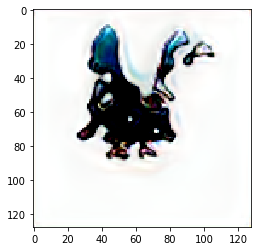

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


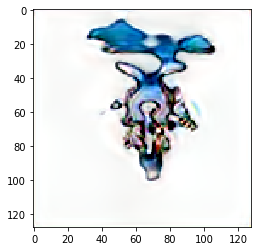

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


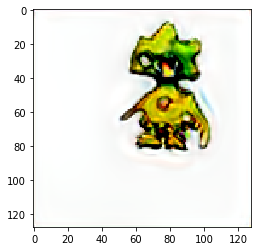

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


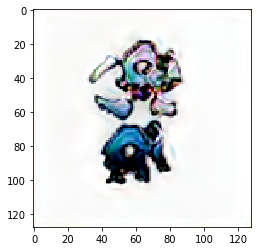

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


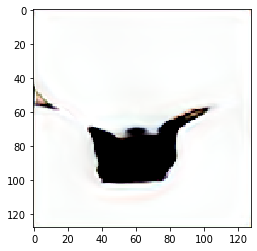

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


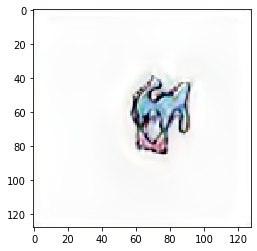

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


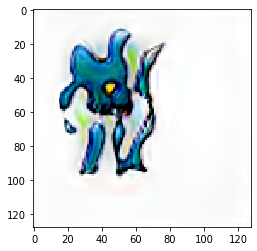

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


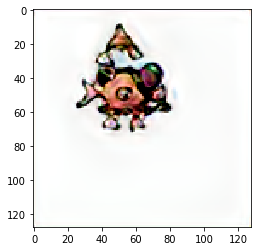

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


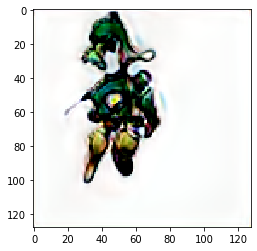

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


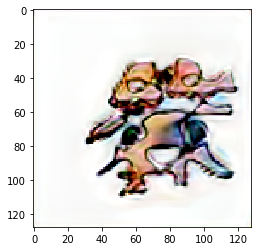

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


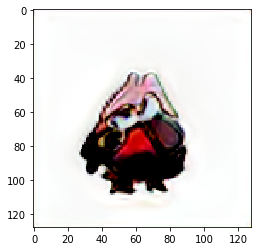

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


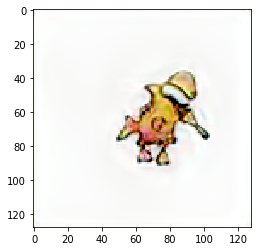

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


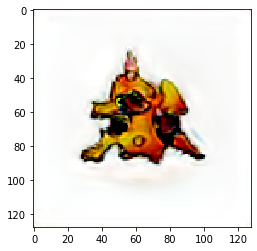

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


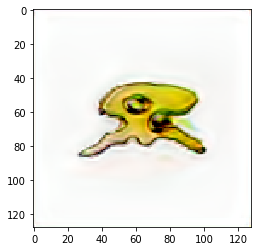

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


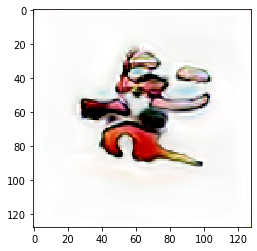

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


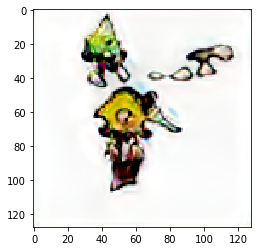

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


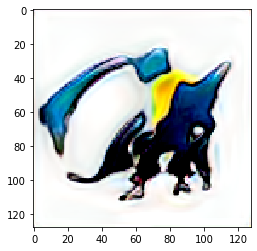

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


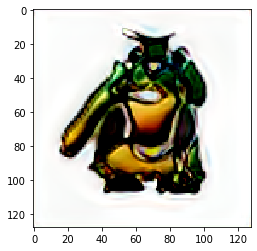

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


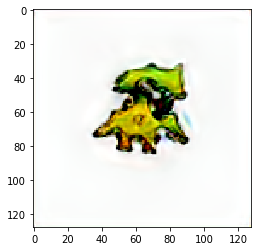

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


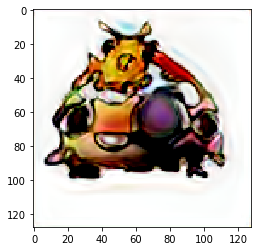

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


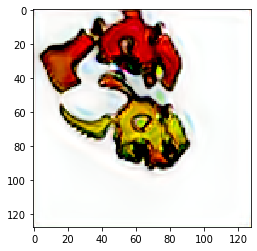

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


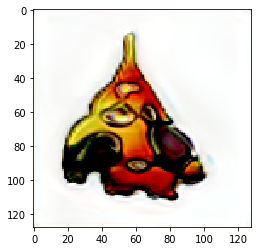

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


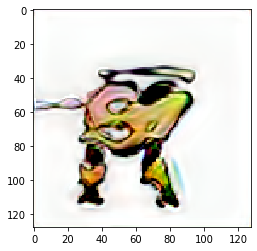

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


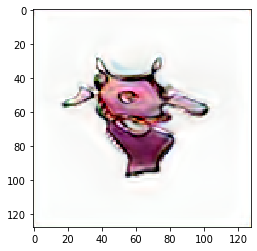

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


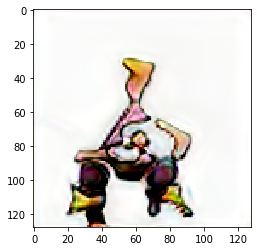

In [83]:
import warnings
warnings.filterwarnings('ignore')

images = g_running(torch.randn(5 * 5, 128).to(device), step = 5, alpha=1).data.cpu()
for image in images:
    image_numpy = image.permute(1, 2, 0).numpy()
    plt.imshow(image_numpy)
    plt.show()

# **Etude des Loss et Gradient**

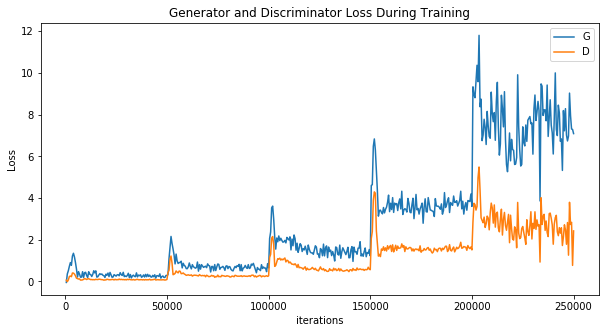

In [25]:
import os
file_path = os.path.join(os.getcwd(), 'log_folder/generator_discriminator_values')

%matplotlib inline
import matplotlib.pyplot as plt

with open(file_path, 'r') as file:
    logs_dict = {}
    titles = next(file).rstrip('\n').split(',')
    for title in titles:
        logs_dict[title] = []
    file_reader = file.readlines()
    for line in file_reader:
        values = list(map(float, line.rstrip('\n').split(',')))
        for i in range(len(titles)):
            logs_dict[titles[i]].append(values[i])

X = list(range(500, 250001, 500))
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(X, logs_dict['generator'],label="G")
plt.plot(X, logs_dict['discriminator'],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

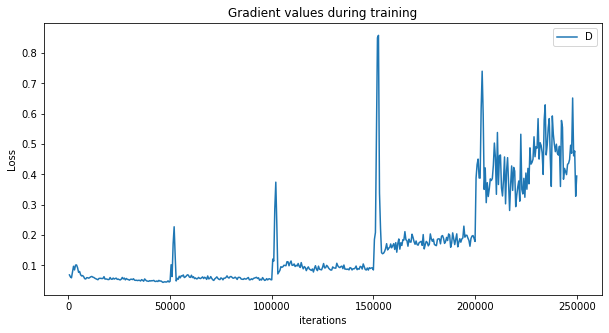

In [26]:
plt.figure(figsize=(10,5))
plt.title("Gradient values during training")
plt.plot(X, logs_dict['gradient'],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
torch.save(g_running.state_dict(), 'log_folder/generator.model')
torch.save(discriminator.state_dict(), 'log_folder/discriminator.model')